# 📚 Diamonds 데이터 분석 캡스톤

In [42]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, concat, pivot_table, get_dummies
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from scipy.stats import t, ttest_ind, normaltest, bartlett, levene
from math import sqrt


# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson, pearsonr, spearmanr
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova, pairwise_tukey, pairwise_gameshowell

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator

# 파이썬 기본 패키지
from itertools import combinations

In [43]:
origin = load_data("diamonds")
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성 조사한 데이터 셋 (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------
price    다이아몬드 가격 (USD, $326 ~ $18,823)
carat    중량 (0.2~5.01)
cut      컷 품질 (Fair, Good, Very Good, Premium, Ideal)
color    색상 등급 - J (worst) to D (best)
clarity  투명도 등급 (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        길이 mm (0~10.74)
y        너비 mm (0--58.9)
z        두께 mm (0--31.8)
depth    비율 정보 = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    다이아몬드의 가장 넓은 지점에 비해 상단(테이블)의 너비 (43--95)


===== 데이터 크기 확인 =====
데이터셋 크기: (53940, 10)
열 개수: 10
행 개수: 53940

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 

price  carat      cut color clarity     x     y     z  depth  table
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0

## 과제 1. 이 데이터는 얼마나 믿을 수 있을까?

In [44]:
origin.describe().T

count         mean          std    min     25%      50%      75%  \
price  53940.0  3932.799722  3989.439738  326.0  950.00  2401.00  5324.25   
carat  53940.0     0.797940     0.474011    0.2    0.40     0.70     1.04   
x      53940.0     5.731157     1.121761    0.0    4.71     5.70     6.54   
y      53940.0     5.734526     1.142135    0.0    4.72     5.71     6.54   
z      53940.0     3.538734     0.705699    0.0    2.91     3.53     4.04   
depth  53940.0    61.749405     1.432621   43.0   61.00    61.80    62.50   
table  53940.0    57.457184     2.234491   43.0   56.00    57.00    59.00   

            max  
price  18823.00  
carat      5.01  
x         10.74  
y         58.90  
z         31.80  
depth     79.00  
table     95.00

#### x(길이),y(높이),z(깊이) 에서 0으로 보이는 값들이 존재 한다.

#### 비어 있는 값이 있는가?(결측치)

In [45]:
df = origin.copy()
df.isna().sum()

price      0
carat      0
cut        0
color      0
clarity    0
x          0
y          0
z          0
depth      0
table      0
dtype: int64

#### 결측치는 존재하지 않는 것으로 보인다.

In [46]:
for i in ["cut", "color", "clarity"]:
    print(df[i].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


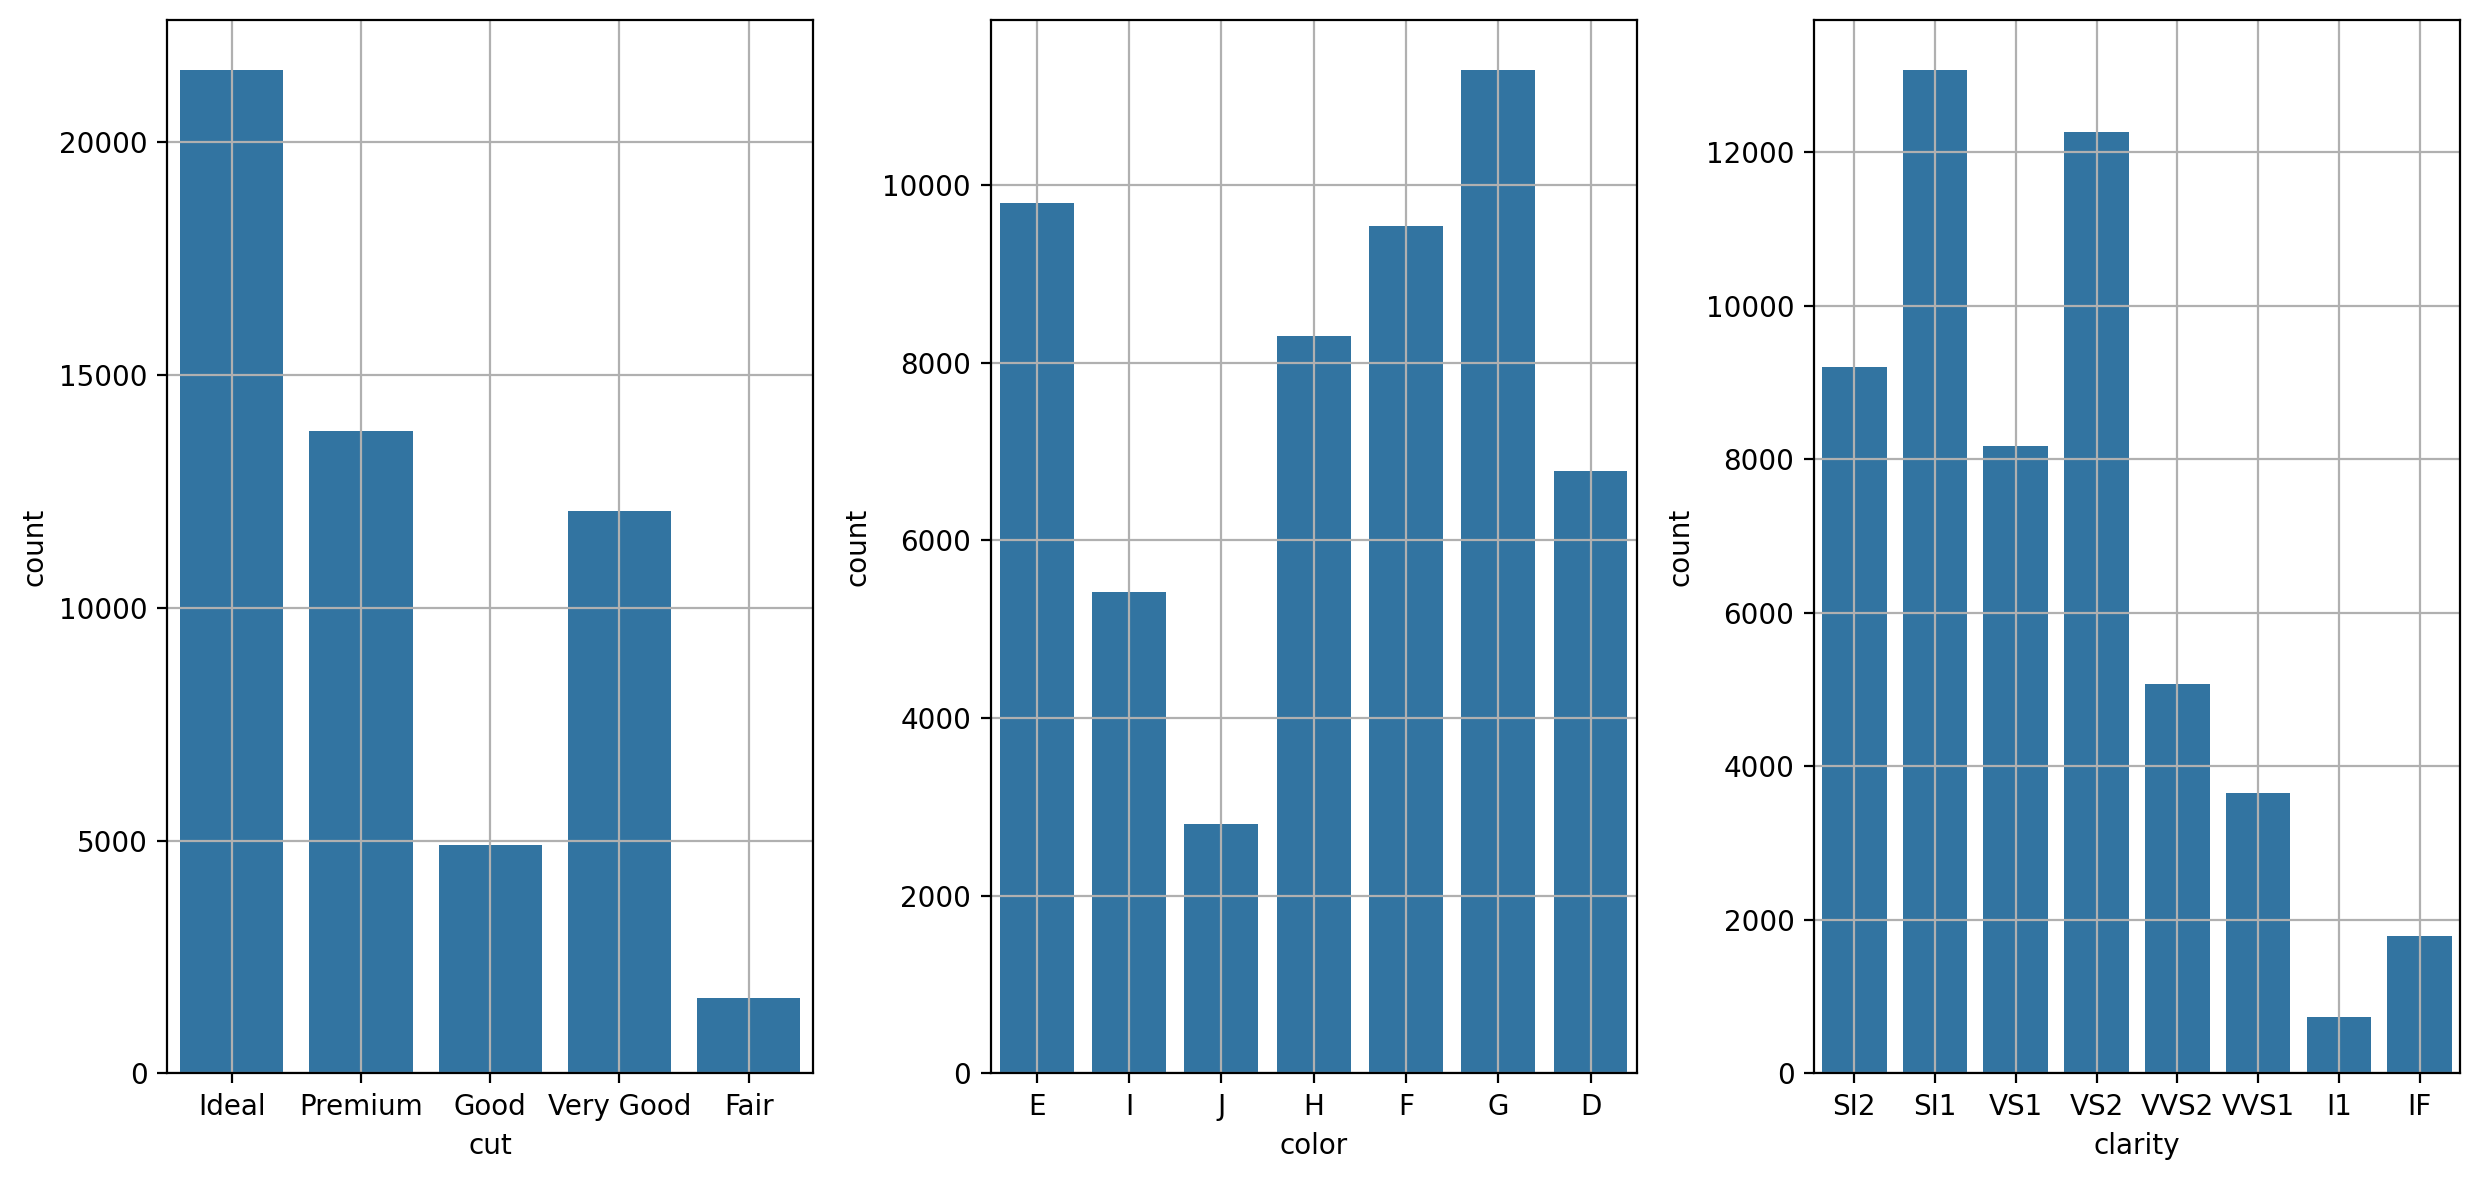

In [47]:
data = ["cut", "color", "clarity"]

# 1) 그래프 초기화 (밖에서 한 번만)
rows = 1
cols = len(data)
width_px = 2500
height_px = 1200
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(data):
    sb.countplot(data=df, x=v, ax=ax[i])
    ax[i].grid(True)

plt.tight_layout()
plt.show()
plt.close()

cut: Ideal 범주의 빈도가 가장 많고, Fair가 가장 적다.

color: G 범주의 빈도가 가장 많고, J가 가장 적다.

clarity: I1 범주의 빈도가 가장 적으며, 상대적으로 SI1, VS2 등의 범주에 데이터가 많이 분포한다.



In [48]:
df.duplicated().sum()

np.int64(146)

In [49]:
df = df.drop_duplicates()

146개의 중복 행이 검사됨. 이를 제거 후 이어서 분석 진행.

In [50]:
# x, y, z 값이 0 이하인 데이터 비율 확인

print(
    "x, y, z 값이 0 이하인 데이터 수 :",
    df[(df["x"] <= 0) | (df["y"] <= 0) | (df["z"] <= 0)]["price"].count(),
)
print(
    "x, y, z 값이 0 이하인 데이터 비율 :",
    (df[(df["x"] <= 0) | (df["y"] <= 0) | (df["z"] <= 0)]["price"].count())
    / len(df)
    * 100,
)

x, y, z 값이 0 이하인 데이터 수 : 19
x, y, z 값이 0 이하인 데이터 비율 : 0.03531992415511024


x,y,z 에 관하여 0인 값들이 19개 존재하는 것으로 보여지며 0 이하의 값들은 존재 하지 않는다
다이아몬드는 물리적 실체를 가지므로 길이(x), 너비(y), 깊이(z) 중 하나라도 0인 값은 현실적으로 불가능한 기록(측정 오류)로 판단하였다. 따라서 x, y, z 중 하나라도 0인 관측치는 제거한 후 분석을 진행하였다.

In [54]:
xyz = ["x", "y", "z"]
df1 = df[(df[xyz] != 0).all(axis=1)]
df1

price  carat        cut color clarity     x     y     z  depth  table
0        326   0.23      Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0
1        326   0.21    Premium     E     SI1  3.89  3.84  2.31   59.8   61.0
2        327   0.23       Good     E     VS1  4.05  4.07  2.31   56.9   65.0
3        334   0.29    Premium     I     VS2  4.20  4.23  2.63   62.4   58.0
4        335   0.31       Good     J     SI2  4.34  4.35  2.75   63.3   58.0
...      ...    ...        ...   ...     ...   ...   ...   ...    ...    ...
53935   2757   0.72      Ideal     D     SI1  5.75  5.76  3.50   60.8   57.0
53936   2757   0.72       Good     D     SI1  5.69  5.75  3.61   63.1   55.0
53937   2757   0.70  Very Good     D     SI1  5.66  5.68  3.56   62.8   60.0
53938   2757   0.86    Premium     H     SI2  6.15  6.12  3.74   61.0   58.0
53939   2757   0.75      Ideal     D     SI2  5.83  5.87  3.64   62.2   55.0

[53775 rows x 10 columns]

In [55]:
((df1[xyz] == 0).sum(axis=1) > 0).sum()

np.int64(0)

## 미션 2. “가격 데이터는 어떤 모습일까?”

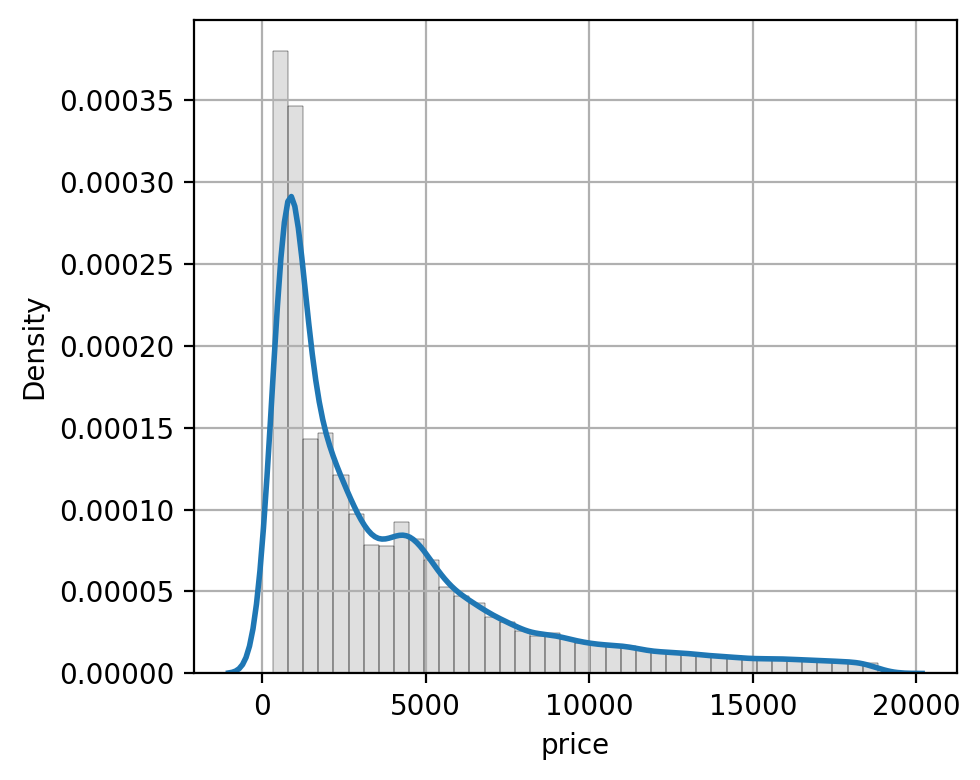

In [85]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
# (1) 히스토그램: alpha로 연하게 + 테두리 제거(또는 얇게)
sb.histplot(
    data=df1,
    x="price",
    bins=40,
    stat="density",
    color="grey",
    alpha=0.25,
    edgecolor="#000000",
    linewidth=0.15,
    ax=ax,
)

# (2) KDE: 선만 또는 fill을 아주 약하게
sb.kdeplot(
    data=df1,
    x="price",
    fill=False,  # 채우면 겹쳐서 진해질 수 있어 우선 False 추천
    linewidth=2,
    ax=ax,
)

# 3) 그래프 꾸미기
ax.grid(True)

plt.tight_layout()
plt.show()
plt.close()

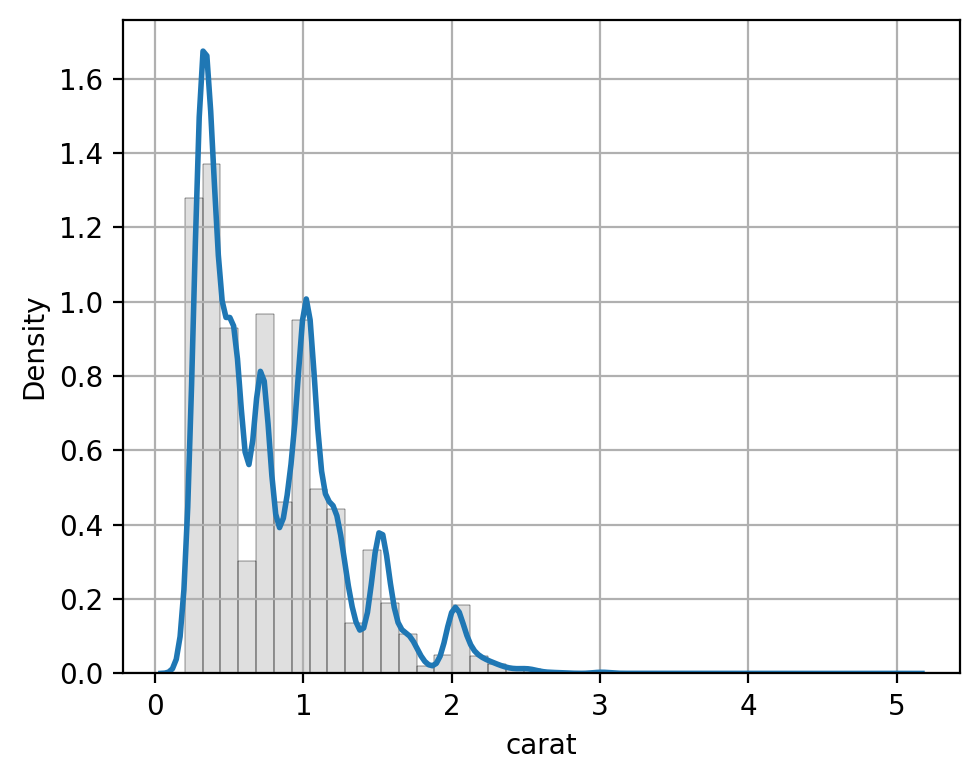

In [87]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
# (1) 히스토그램: alpha로 연하게 + 테두리 제거(또는 얇게)
sb.histplot(
    data=df1,
    x="carat",
    bins=40,
    stat="density",
    color="grey",
    alpha=0.25,
    edgecolor="#000000",
    linewidth=0.15,
    ax=ax,
)

# (2) KDE: 선만 또는 fill을 아주 약하게
sb.kdeplot(
    data=df1,
    x="carat",
    fill=False,  # 채우면 겹쳐서 진해질 수 있어 우선 False 추천
    linewidth=2,
    ax=ax,
)

# 3) 그래프 꾸미기
ax.grid(True)

plt.tight_layout()
plt.show()
plt.close()

price와 carat의 분포를 확인한 결과, 두 변수 모두 낮은 값에 데이터가 몰려 있고 높은 값 방향으로 꼬리가 길게 나타났다. 이런 형태는 정규분포와는 거리가 있어 보이므로, 그대로 회귀분석을 진행하면 잔차도 한쪽으로 치우쳐 해석이 어려울 수 있다. 따라서 회귀를 바로 진행하기보다는 로그 변환처럼 분포를 완화하는 방법을 검토할 필요가 있다.

## 미션 3. “로그 변환은 왜 등장할까?”

In [58]:
df2 = df1.copy()
df2["log_price"] = np.log(df2["price"])
df2["log_carat"] = np.log(df2["carat"])
df2.head()

price  carat      cut color clarity     x     y     z  depth  table  \
0    326   0.23    Ideal     E     SI2  3.95  3.98  2.43   61.5   55.0   
1    326   0.21  Premium     E     SI1  3.89  3.84  2.31   59.8   61.0   
2    327   0.23     Good     E     VS1  4.05  4.07  2.31   56.9   65.0   
3    334   0.29  Premium     I     VS2  4.20  4.23  2.63   62.4   58.0   
4    335   0.31     Good     J     SI2  4.34  4.35  2.75   63.3   58.0   

   log_price  log_carat  
0   5.786897  -1.469676  
1   5.786897  -1.560648  
2   5.789960  -1.469676  
3   5.811141  -1.237874  
4   5.814131  -1.171183

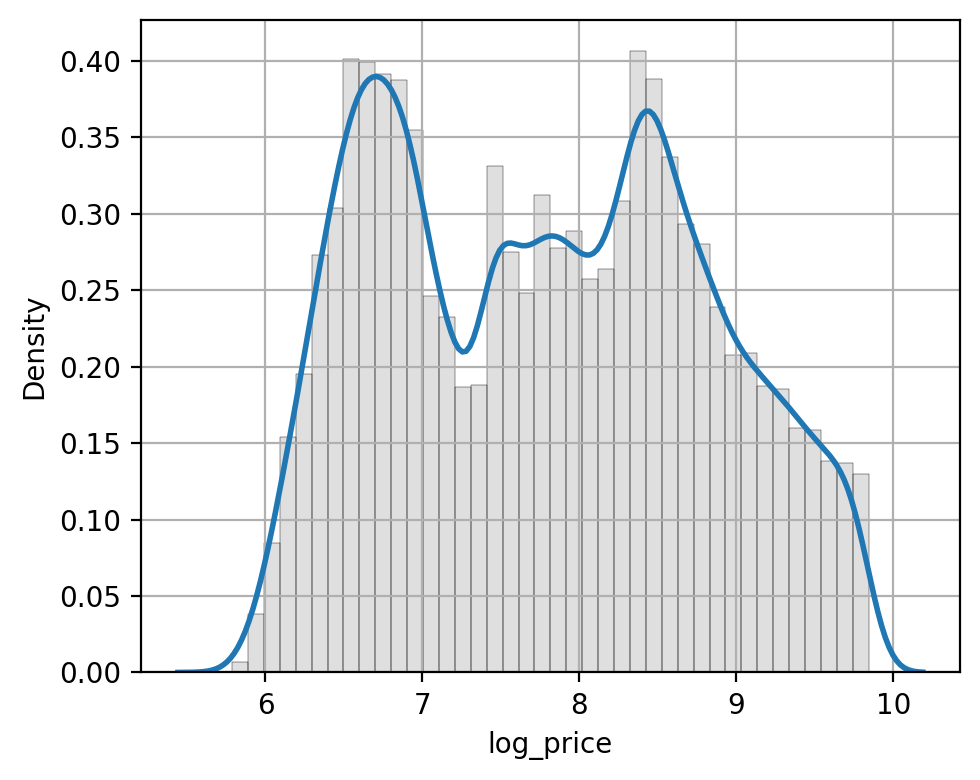

In [88]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
# (1) 히스토그램: alpha로 연하게 + 테두리 제거(또는 얇게)
sb.histplot(
    data=df2,
    x="log_price",
    bins=40,
    stat="density",
    color="grey",
    alpha=0.25,
    edgecolor="#000000",
    linewidth=0.15,
    ax=ax,
)

# (2) KDE: 선만 또는 fill을 아주 약하게
sb.kdeplot(
    data=df2,
    x="log_price",
    fill=False,  # 채우면 겹쳐서 진해질 수 있어 우선 False 추천
    linewidth=2,
    ax=ax,
)

# 3) 그래프 꾸미기
ax.grid(True)

plt.tight_layout()
plt.show()
plt.close()

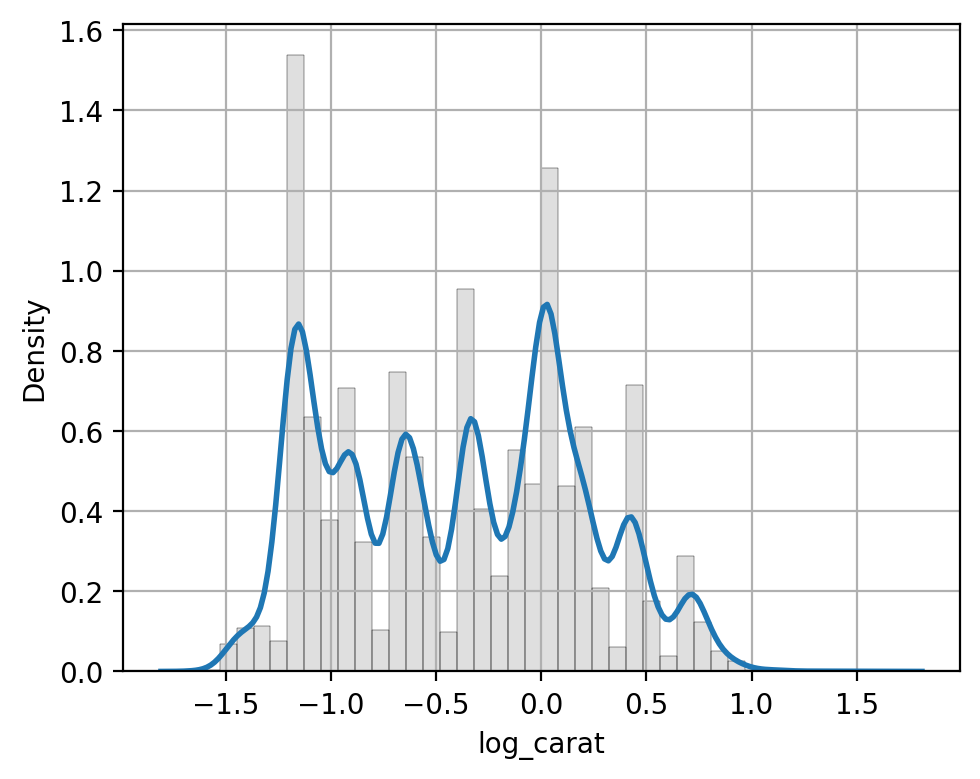

In [90]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
# (1) 히스토그램: alpha로 연하게 + 테두리 제거(또는 얇게)
sb.histplot(
    data=df2,
    x="log_carat",
    bins=40,
    stat="density",
    color="grey",
    alpha=0.25,
    edgecolor="#000000",
    linewidth=0.15,
    ax=ax,
)

# (2) KDE: 선만 또는 fill을 아주 약하게
sb.kdeplot(
    data=df2,
    x="log_carat",
    fill=False,  # 채우면 겹쳐서 진해질 수 있어 우선 False 추천
    linewidth=2,
    ax=ax,
)

# 3) 그래프 꾸미기
ax.grid(True)

plt.tight_layout()
plt.show()
plt.close()

가격과 carat에 로그 변환을 한 결과 큰 값은 눌러서 작아지고, 작은 값은 상대적으로 덜 변해서 전체 분포가 더 균형 있게 보이게 된다.  
로그 변환 후 히스토그램을 보면 변환 전보다 오른쪽으로 길게 늘어진 꼬리가 줄어든 느낌이 있다. 즉, 극단적으로 큰 값의 영향이 줄었다고 볼 수 있다.  
다만 정규성 검정을 하면 p-value가 0에 가까워서 정규성은 충족 되지 않는다  
즉 로그 변환은 정규분포를 완벽하게 만들기보다는 치우친 분포를 덜 치우치게 만들고 극단값을 줄여서 이후 회귀분석을 더 안정적으로 하기 위해 사용한다.  

## 미션 4. “품질 등급은 가격을 얼마나 설명해 줄까?

In [91]:
order = {
    "cut": ["Ideal", "Premium", "Very Good", "Good", "Fair"],
    "color": ["D", "E", "F", "G", "H", "I", "J"],
    "clarity": ["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1"],
}

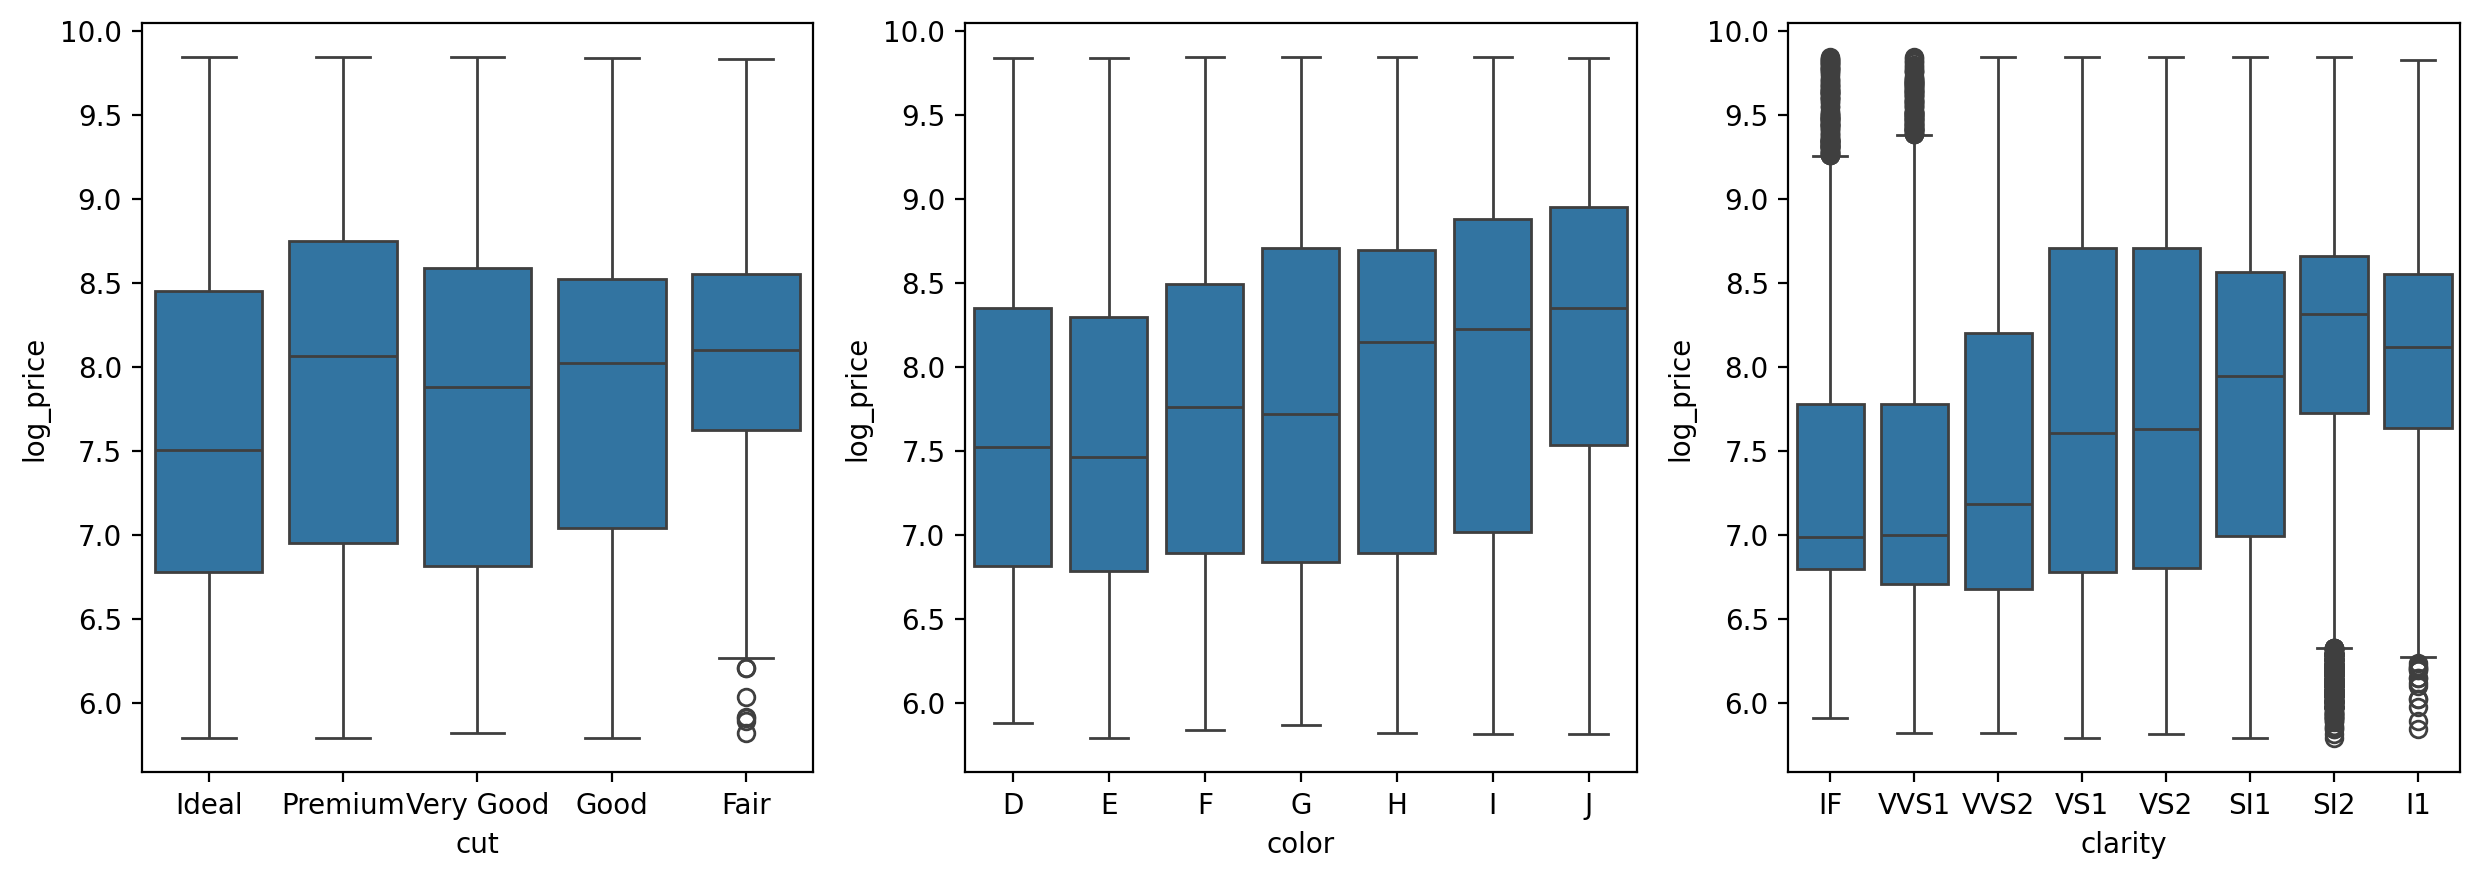

In [92]:
data = ["cut", "color", "clarity"]


# 1) 그래프 초기화
rows = 1
cols = len(data)
width_px = 2500
height_px = 900
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(data):
    sb.boxplot(data=df2, x=v, y="log_price", order=order[v], ax=ax[i])

plt.tight_layout()
plt.show()
plt.close()

cut 기준으로는 Premium의 중앙값이 상대적으로 높고, 박스 폭도 넓어 가격 변동(분산)이 큰 편으로 보인다. Fair는 박스 폭은 비교적 좁지만 이상치가 관찰되어 일부 극단값이 존재함을 확인할 수 있다.

color는 등급 간 가격 분포가 많이 겹쳐, 색상 등급만으로 가격을 뚜렷하게 구분하기 어렵다.

clarity 역시 분포 겹침이 존재해 단독으로 가격을 완전히 가르긴 어렵지만, 세 품질 변수 중에서는 등급별 중앙값 차이가 상대적으로 더 뚜렷하게 나타나 가격 차이를 가장 잘 보여주는 변수로 관찰된다.

결론적으로, 가격 차이가 비교적 뚜렷한 품질 변수는 clarity이고, color는 등급 간 분포 겹침이 커 등급이 달라도 비슷한 가격 구간이 많이 나타난다.

## 미션 5. “Premium 컷은 정말 더 비쌀까?

독립성 t-test를 사용하여 서로 다른 두개의 그룹 간 평균의 차이가 유의미한지 여부를 판단한다.

cut에서 Premium이랑 Ideal등급인 가격정보만 따로 가져온다

In [62]:
df3 = (
    df2.query("cut == 'Premium' or cut == 'Ideal'")[["cut", "log_price"]]
    .dropna()
    .copy()
)

premium = df3.loc[df3["cut"] == "Premium", "log_price"].reset_index(drop=True)
ideal = df3.loc[df3["cut"] == "Ideal", "log_price"].reset_index(drop=True)

df4 = concat([premium, ideal], axis=1)
df4.columns = ["Premium", "Ideal"]
df4

Premium     Ideal
0      5.786897  5.786897
1      5.811141  5.828946
2      5.834811  5.840642
3      5.843544  5.852202
4      5.843544  5.998937
...         ...       ...
21480       NaN  7.921536
21481       NaN  7.921536
21482       NaN  7.921536
21483       NaN  7.921898
21484       NaN  7.921898

[21485 rows x 2 columns]

각각의 인덱스를 초기화 후 하나의 행으로 합쳤다

In [63]:
data = df4[["Premium", "Ideal"]]

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    x = data[c].dropna()  # 결측치 제거

    s, p = normaltest(x)
    normalize = p > 0.05

    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})

    normal_dist = normal_dist and normalize
    equal_var_fields.append(x)

# 정규성 결과에 따라 등분산 검정 선택
if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields, center="median")

equal_var = p > 0.05

report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

statistic       p-value  result
field                                     
Premium  9858.052388  0.000000e+00   False
Ideal    4653.410445  0.000000e+00   False
Levene     71.293568  3.194522e-17   False

Premium과 Ideal의 log_price에 대해 정규성 검정을 수행한 결과 두 그룹 모두 p-value≈0으로 정규성 가정이 충족되지 않았고, Levene 검정에서도 p<0.05 이므로 등분산 가정이 위배되었다.
따라서 등분산 가정 없이 평균 차이를 비교할 수 있는 Welch t-test를 적용한다.

In [64]:
s, p = ttest_ind(
    df4["Premium"].dropna(),
    df4["Ideal"].dropna(),
    equal_var=False,
    alternative="greater",
)

result = "statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(
    s, p, "대립" if p <= 0.05 else "귀무"
)
print(result)

statistic: 27.857, p-value: 0.000, 대립가설 채택


p = 3.79e-171로 (p<0.05) 귀무가설을 기각하였다. 따라서 Premium의 평균(log_price)은 Ideal보다 통계적으로 유의하게 더 크다

## 📝미션 6. “모든 컷은 서로 다를까?”

In [65]:
df6 = df2[["cut", "log_price"]].dropna().copy()
df6

cut  log_price
0          Ideal   5.786897
1        Premium   5.786897
2           Good   5.789960
3        Premium   5.811141
4           Good   5.814131
...          ...        ...
53935      Ideal   7.921898
53936       Good   7.921898
53937  Very Good   7.921898
53938    Premium   7.921898
53939      Ideal   7.921898

[53775 rows x 2 columns]

In [66]:
field = "log_price"
hue_field = "cut"

df = df6[[field, hue_field]].copy()
df["idx"] = df.groupby(hue_field).cumcount()

data = pivot_table(df, index="idx", columns=hue_field, values=field, aggfunc="first")


normal_dist = True
report = []
values = []

for c in data.columns:
    target = data[c].dropna()
    values.append(target)

    s, p = normaltest(target)
    normalize = p > 0.05
    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

# 등분산성
if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*values)
else:
    n = "Levene"
    s, p = levene(*values, center="median")

equal_var = p > 0.05
report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

statistic        p-value  result
field                                        
Fair          5.325422   6.975886e-02    True
Good        707.152681  2.778090e-154   False
Ideal      4653.410445   0.000000e+00   False
Premium    9858.052388   0.000000e+00   False
Very Good  4677.135155   0.000000e+00   False
Levene      122.349875  3.939566e-104   False

cut별 log_price 분포에 대해 가정 검정을 수행한 결과, 대부분의 컷은 정규성이 충족되지 않았고, Levene 검정에서도 p=2.49e-104로 등분산성이 명확히 위배되었다.
따라서 등분산을 전제로 하는 일반 일원분산분석보다는, 등분산 가정 없이 컷 간 평균 차이를 검정할 수 있는 방법을 적용하는 것이 타당하다.

In [67]:
anova_df = df6[[field, hue_field]]

if equal_var:
    pg_anova = anova(data=anova_df, dv=field, between=hue_field)
else:
    pg_anova = welch_anova(data=anova_df, dv=field, between=hue_field)

display(pg_anova)

f_val = pg_anova["F"].iloc[0]
p_val = pg_anova["p-unc"].iloc[0]
print(
    "statistic: {0:.3f}, p-value: {1:.3g}, {2}가설 채택".format(
        f_val, p_val, "대립" if p_val <= 0.05 else "귀무"
    )
)

if equal_var:
    print("== Tukey HSD ==")
    hoc_df = pairwise_tukey(data=anova_df, dv=field, between=hue_field)
else:
    print("== Games-Howell ==")
    hoc_df = pairwise_gameshowell(anova_df, dv=field, between=hue_field)

display(hoc_df)

Source  ddof1        ddof2           F          p-unc       np2
0    cut      4  9493.334892  268.919636  2.605876e-219  0.017814

statistic: 268.920, p-value: 2.61e-219, 대립가설 채택
== Games-Howell ==


A          B   mean(A)   mean(B)      diff        se          T  \
0     Fair       Good  8.090289  7.840509  0.249780  0.023727  10.527108   
1     Fair      Ideal  8.090289  7.640958  0.449331  0.020303  22.131770   
2     Fair    Premium  8.090289  7.949959  0.140330  0.021060   6.663216   
3     Fair  Very Good  8.090289  7.798623  0.291666  0.021342  13.666427   
4     Good      Ideal  7.840509  7.640958  0.199551  0.015572  12.814638   
5     Good    Premium  7.840509  7.949959 -0.109450  0.016548  -6.614109   
6     Good  Very Good  7.840509  7.798623  0.041886  0.016905   2.477781   
7    Ideal    Premium  7.640958  7.949959 -0.309001  0.011093 -27.856757   
8    Ideal  Very Good  7.640958  7.798623 -0.157665  0.011618 -13.570723   
9  Premium  Very Good  7.949959  7.798623  0.151337  0.012897  11.734559   

             df          pval    hedges  
0   3445.043360  1.948108e-12  0.267979  
1   2018.137568  4.981571e-13  0.459203  
2   2327.464969  3.321803e-10  0.139562  
3   2447.897947  0.000000e+00  0.289017  
4   7340.800370  4.550804e-13  0.201506  
5   8984.457292  4.000353e-10 -0.107612  
6   9528.343382  9.574532e-02  0.041019  
7  28475.738548  0.000000e+00 -0.306785  
8  24093.884656  2.653544e-12 -0.156290  
9  25329.519422  0.000000e+00  0.146468

Welch ANOVA 결과, cut에 따라 log_price 평균은 유의하게 달라 귀무가설을 기각하였다(p = 2.74e-223). 즉, 컷 등급에 따른 가격 차이가 전반적으로 존재함이 통계적으로 확인되었다.
평균(log_price)은 Fair(8.093) > Premium(7.950) > Good(7.842) > Very Good(7.799) > Ideal(7.639) 순으로 나타났다.
사후검정에서는 Good–Very Good만 유의한 차이가 없었으며(p=0.072), 그 외 모든 조합은 유의했다. 따라서 유의성까지 반영한 서열은 Fair > Premium > Good ≈ Very Good > Ideal로 정리된다.

## 📝미션 7. “품질 요인들은 서로 영향을 주고받을까?”

원할한 분석을 위하여 각각의 값만 따로 데이터프레임을 뽑아 분석하기 쉽게 전처리 해주었다.

In [68]:
df7 = df2[["cut", "color", "log_price"]].copy()
df7

cut color  log_price
0          Ideal     E   5.786897
1        Premium     E   5.786897
2           Good     E   5.789960
3        Premium     I   5.811141
4           Good     J   5.814131
...          ...   ...        ...
53935      Ideal     D   7.921898
53936       Good     D   7.921898
53937  Very Good     D   7.921898
53938    Premium     H   7.921898
53939      Ideal     D   7.921898

[53775 rows x 3 columns]

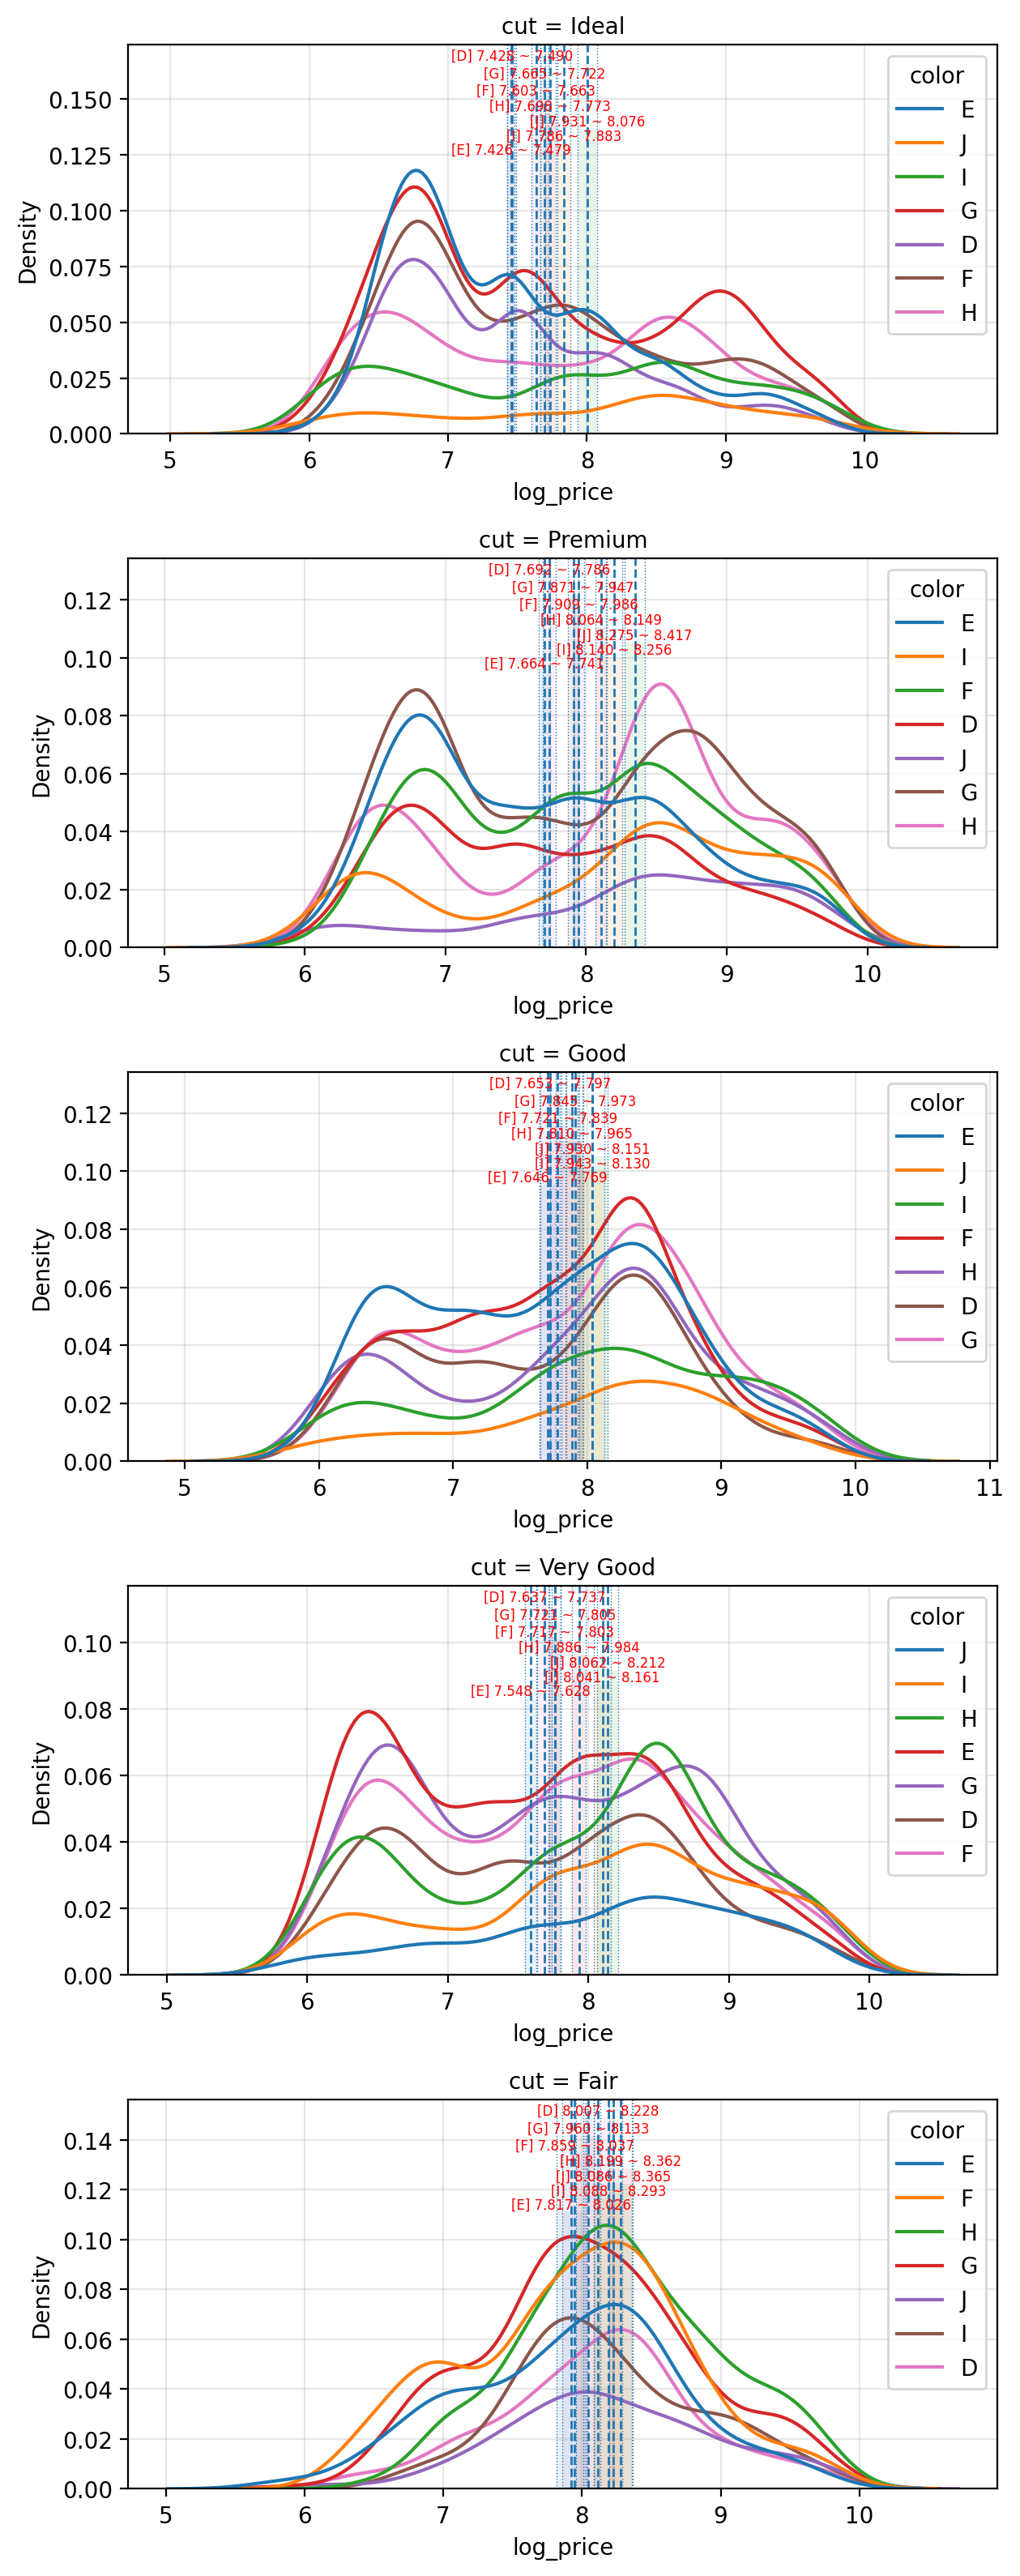

In [69]:
field = "log_price"
group_field = "cut"
hue_field = "color"


data = df2[[field, group_field, hue_field]].dropna().copy()

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]

    # KDE Plot
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        n = len(temp_sub[field])

        # 표본이 너무 적으면 신뢰구간 계산 불가 → 스킵
        if n < 2:
            continue

        clevel = 0.95
        dof = n - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(n)

        # 표준오차가 0/NaN이면 스킵
        if not (sp_std_error > 0):
            continue

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        # 신뢰구간 경계선
        ax[i].axvline(cmin, linestyle=":", linewidth=0.5)
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5)

        # 평균 및 신뢰구간 영역 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle="--", linewidth=1)

        # 텍스트
        ax[i].text(
            x=(cmax - cmin) / 2 + cmin,
            y=ymax,
            s="[%s] %0.3f ~ %0.3f" % (h, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"},
        )

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

In [70]:
data = df7.copy()

xname = ["cut", "color"]
yname = "log_price"

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()

equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname].dropna()
        if len(filtered) == 0:
            continue

        equal_var_fields.append(filtered)

        s, p = normaltest(filtered)
        normalize = p > 0.05

        report.append(
            {
                "field": "{0}={1}, {2}={3}".format(xname[0], i, xname[1], j),
                "statistic": s,
                "p-value": p,
                "result": normalize,
            }
        )

        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields, center="median")

equal_var = p > 0.05

report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

statistic        p-value  result
field                                                      
cut=Ideal, color=E        308.571096   9.877292e-68   False
cut=Ideal, color=I       2764.050631   0.000000e+00   False
cut=Ideal, color=J        255.253793   3.735452e-56   False
cut=Ideal, color=H       4362.667241   0.000000e+00   False
cut=Ideal, color=F        529.434863  1.083129e-115   False
cut=Ideal, color=G       2468.268467   0.000000e+00   False
cut=Ideal, color=D        211.390017   1.250953e-46   False
cut=Premium, color=E      357.297112   2.593689e-78   False
cut=Premium, color=I      311.285498   2.542219e-68   False
cut=Premium, color=J       65.091277   7.338526e-15   False
cut=Premium, color=H      638.612573  2.123449e-139   False
cut=Premium, color=F      818.201710  2.136762e-178   False
cut=Premium, color=G    14916.021792   0.000000e+00   False
cut=Premium, color=D      410.691855   6.597765e-90   False
cut=Good, color=E         185.552345   5.102938e-41   False
cut=Good, color=I          65.625740   5.617609e-15   False
cut=Good, color=J          20.122864   4.269486e-05   False
cut=Good, color=H         111.148271   7.319132e-25   False
cut=Good, color=F          56.996021   4.202148e-13   False
cut=Good, color=G         124.042260   1.160287e-27   False
cut=Good, color=D         148.752382   4.998396e-33   False
cut=Very Good, color=E    653.882727  1.026053e-142   False
cut=Very Good, color=I    120.715352   6.123425e-27   False
cut=Very Good, color=J     46.487152   8.043465e-11   False
cut=Very Good, color=H    491.642246  1.742781e-107   False
cut=Very Good, color=F    606.367121  2.133303e-132   False
cut=Very Good, color=G   1653.002417   0.000000e+00   False
cut=Very Good, color=D    382.880686   7.219636e-84   False
cut=Fair, color=E           2.070356   3.551631e-01    True
cut=Fair, color=I           3.705958   1.567695e-01    True
cut=Fair, color=J           0.003373   9.983151e-01    True
cut=Fair, color=H           4.366171   1.126933e-01    True
cut=Fair, color=F           5.104536   7.790477e-02    True
cut=Fair, color=G           2.909528   2.334554e-01    True
cut=Fair, color=D           0.880055   6.440189e-01    True
Levene                     39.373034  3.996619e-256   False

In [71]:
xname = ["cut", "color"]
yname = "log_price"
data = df7[xname + [yname]]

pg_anova = anova(data=data, dv=yname, between=xname, detailed=True)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row["Source"]
    p_val = row["p-unc"]

    if p_val <= 0.05:
        print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

Source            SS       DF          MS           F          p-unc  \
0          cut    882.570850      4.0  220.642712  224.008090  4.768926e-191   
1        color   1312.829796      6.0  218.804966  222.142313  2.703293e-281   
2  cut * color     94.129853     24.0    3.922077    3.981899   1.739256e-10   
3     Residual  52932.639061  53740.0    0.984977         NaN            NaN   

        np2  
0  0.016400  
1  0.024202  
2  0.001775  
3       NaN

→ cut 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ color 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ cut * color 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [72]:
xname = ["cut", "color"]
yname = "log_price"

data = df7[xname + [yname]]

levels = {}  # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname:  # 요인을 하나씩 꺼냄
    level_count = data[factor].nunique()  # 요인의 수준 수 계산
    levels[factor] = level_count  # 딕셔너리에 저장

pvals = {}  # 빈 딕셔너리 만들기
# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows():  # 행을 하나씩 꺼냄
    source_name = row["Source"]  # 요인 이름
    p_value = row["p-unc"]  # 각 요인의 p-value
    pvals[source_name] = p_value  # 딕셔너리에 저장

# 주효과 사후검정
for factor in xname:
    print(f"\n[{factor}]")

    # 수준이 2개면 사후검정 필요 없음
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if "*" in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[cut]
- 주효과 유의 (p=4.77e-191) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A          B   mean(A)   mean(B)      diff        se          T  \
0     Fair       Good  8.090289  7.840509  0.249780  0.023727  10.527108   
1     Fair      Ideal  8.090289  7.640958  0.449331  0.020303  22.131770   
2     Fair    Premium  8.090289  7.949959  0.140330  0.021060   6.663216   
3     Fair  Very Good  8.090289  7.798623  0.291666  0.021342  13.666427   
4     Good      Ideal  7.840509  7.640958  0.199551  0.015572  12.814638   
5     Good    Premium  7.840509  7.949959 -0.109450  0.016548  -6.614109   
6     Good  Very Good  7.840509  7.798623  0.041886  0.016905   2.477781   
7    Ideal    Premium  7.640958  7.949959 -0.309001  0.011093 -27.856757   
8    Ideal  Very Good  7.640958  7.798623 -0.157665  0.011618 -13.570723   
9  Premium  Very Good  7.949959  7.798623  0.151337  0.012897  11.734559   

             df          pval    hedges  
0   3445.043360  1.948108e-12  0.267979  
1   2018.137568  4.981571e-13  0.459203  
2   2327.464969  3.321803e-10  0.139562  
3   2447.897947  0.000000e+00  0.289017  
4   7340.800370  4.550804e-13  0.201506  
5   8984.457292  4.000353e-10 -0.107612  
6   9528.343382  9.574532e-02  0.041019  
7  28475.738548  0.000000e+00 -0.306785  
8  24093.884656  2.653544e-12 -0.156290  
9  25329.519422  0.000000e+00  0.146468


[color]
- 주효과 유의 (p=2.7e-281) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A  B   mean(A)   mean(B)      diff        se          T            df  \
0   D  E  7.618173  7.580117  0.038056  0.014652   2.597212  14515.582383   
1   D  F  7.618173  7.762781 -0.144609  0.015014  -9.631319  14916.864602   
2   D  G  7.618173  7.789751 -0.171579  0.014861 -11.545292  15379.789166   
3   D  H  7.618173  7.917375 -0.299202  0.016231 -18.434102  14954.249959   
4   D  I  7.618173  8.020211 -0.402038  0.018794 -21.391367  10523.292778   
5   D  J  7.618173  8.147775 -0.529603  0.022595 -23.439374   4747.645070   
6   E  F  7.580117  7.762781 -0.182664  0.013642 -13.390158  19193.887347   
7   E  G  7.580117  7.789751 -0.209634  0.013473 -15.559550  21000.149239   
8   E  H  7.580117  7.917375 -0.337258  0.014970 -22.528700  16529.605620   
9   E  I  7.580117  8.020211 -0.440094  0.017717 -24.840170   9608.691599   
10  E  J  7.580117  8.147775 -0.567658  0.021707 -26.151383   4165.794903   
11  F  G  7.762781  7.789751 -0.026970  0.013866  -1.945079  20530.433601   
12  F  H  7.762781  7.917375 -0.154594  0.015325 -10.087959  16866.993555   
13  F  I  7.762781  8.020211 -0.257430  0.018018 -14.287763  10050.514889   
14  F  J  7.762781  8.147775 -0.384994  0.021953 -17.537551   4338.982695   
15  G  H  7.789751  7.917375 -0.127624  0.015175  -8.410324  17473.651581   
16  G  I  7.789751  8.020211 -0.230460  0.017890 -12.881935   9993.562714   
17  G  J  7.789751  8.147775 -0.358024  0.021848 -16.386924   4275.821022   
18  H  I  7.917375  8.020211 -0.102836  0.019043  -5.400176  11221.199113   
19  H  J  7.917375  8.147775 -0.230401  0.022802 -10.104463   4936.608079   
20  I  J  8.020211  8.147775 -0.127564  0.024692  -5.166148   5998.441032   

            pval    hedges  
0   1.267697e-01  0.041096  
1   0.000000e+00 -0.152092  
2   0.000000e+00 -0.173158  
3   0.000000e+00 -0.298239  
4   6.181611e-12 -0.398023  
5   1.591172e-12 -0.551687  
6   3.663736e-14 -0.192929  
7   6.617262e-12 -0.213547  
8   0.000000e+00 -0.340476  
9   2.900347e-12 -0.442875  
10  0.000000e+00 -0.596485  
11  4.502827e-01 -0.026951  
12  0.000000e+00 -0.152657  
13  0.000000e+00 -0.252378  
14  1.362688e-12 -0.391283  
15  0.000000e+00 -0.122437  
16  3.828604e-12 -0.218710  
17  0.000000e+00 -0.347760  
18  1.417119e-06 -0.095257  
19  1.368905e-13 -0.218254  
20  5.126327e-06 -0.117808


[cut * color] 상호작용 효과
- 상호작용 유의 (p=1.74e-10) → 단순주효과 분석 필요


log_price(가격)에 대해 cut(컷 등급), color가 각각 어떤 영향을 미치는지와, 또 cut, clarity에 대한 두 요인이 함께 작용할 때를 검증하기 위해 이원 분산분석(2-way ANOVA)을 수행하였다.

cut * color 사후검정(Games–Howell) 결과, 평균(log_price) 차이는 대부분의 조합에서 유의했다(p≤0.05).
평균값(mean) 기준으로는 J(8.146) > I(8.023) > H(7.917) > G(7.789) > F(7.762) > D(7.617) > E(7.579) 순으로 나타난다.
따라서 color는 가격(log_price) 수준을 구분하는 데 의미가 있다.

In [73]:
df8 = df2[["cut", "clarity", "log_price"]].copy()
df8

cut clarity  log_price
0          Ideal     SI2   5.786897
1        Premium     SI1   5.786897
2           Good     VS1   5.789960
3        Premium     VS2   5.811141
4           Good     SI2   5.814131
...          ...     ...        ...
53935      Ideal     SI1   7.921898
53936       Good     SI1   7.921898
53937  Very Good     SI1   7.921898
53938    Premium     SI2   7.921898
53939      Ideal     SI2   7.921898

[53775 rows x 3 columns]

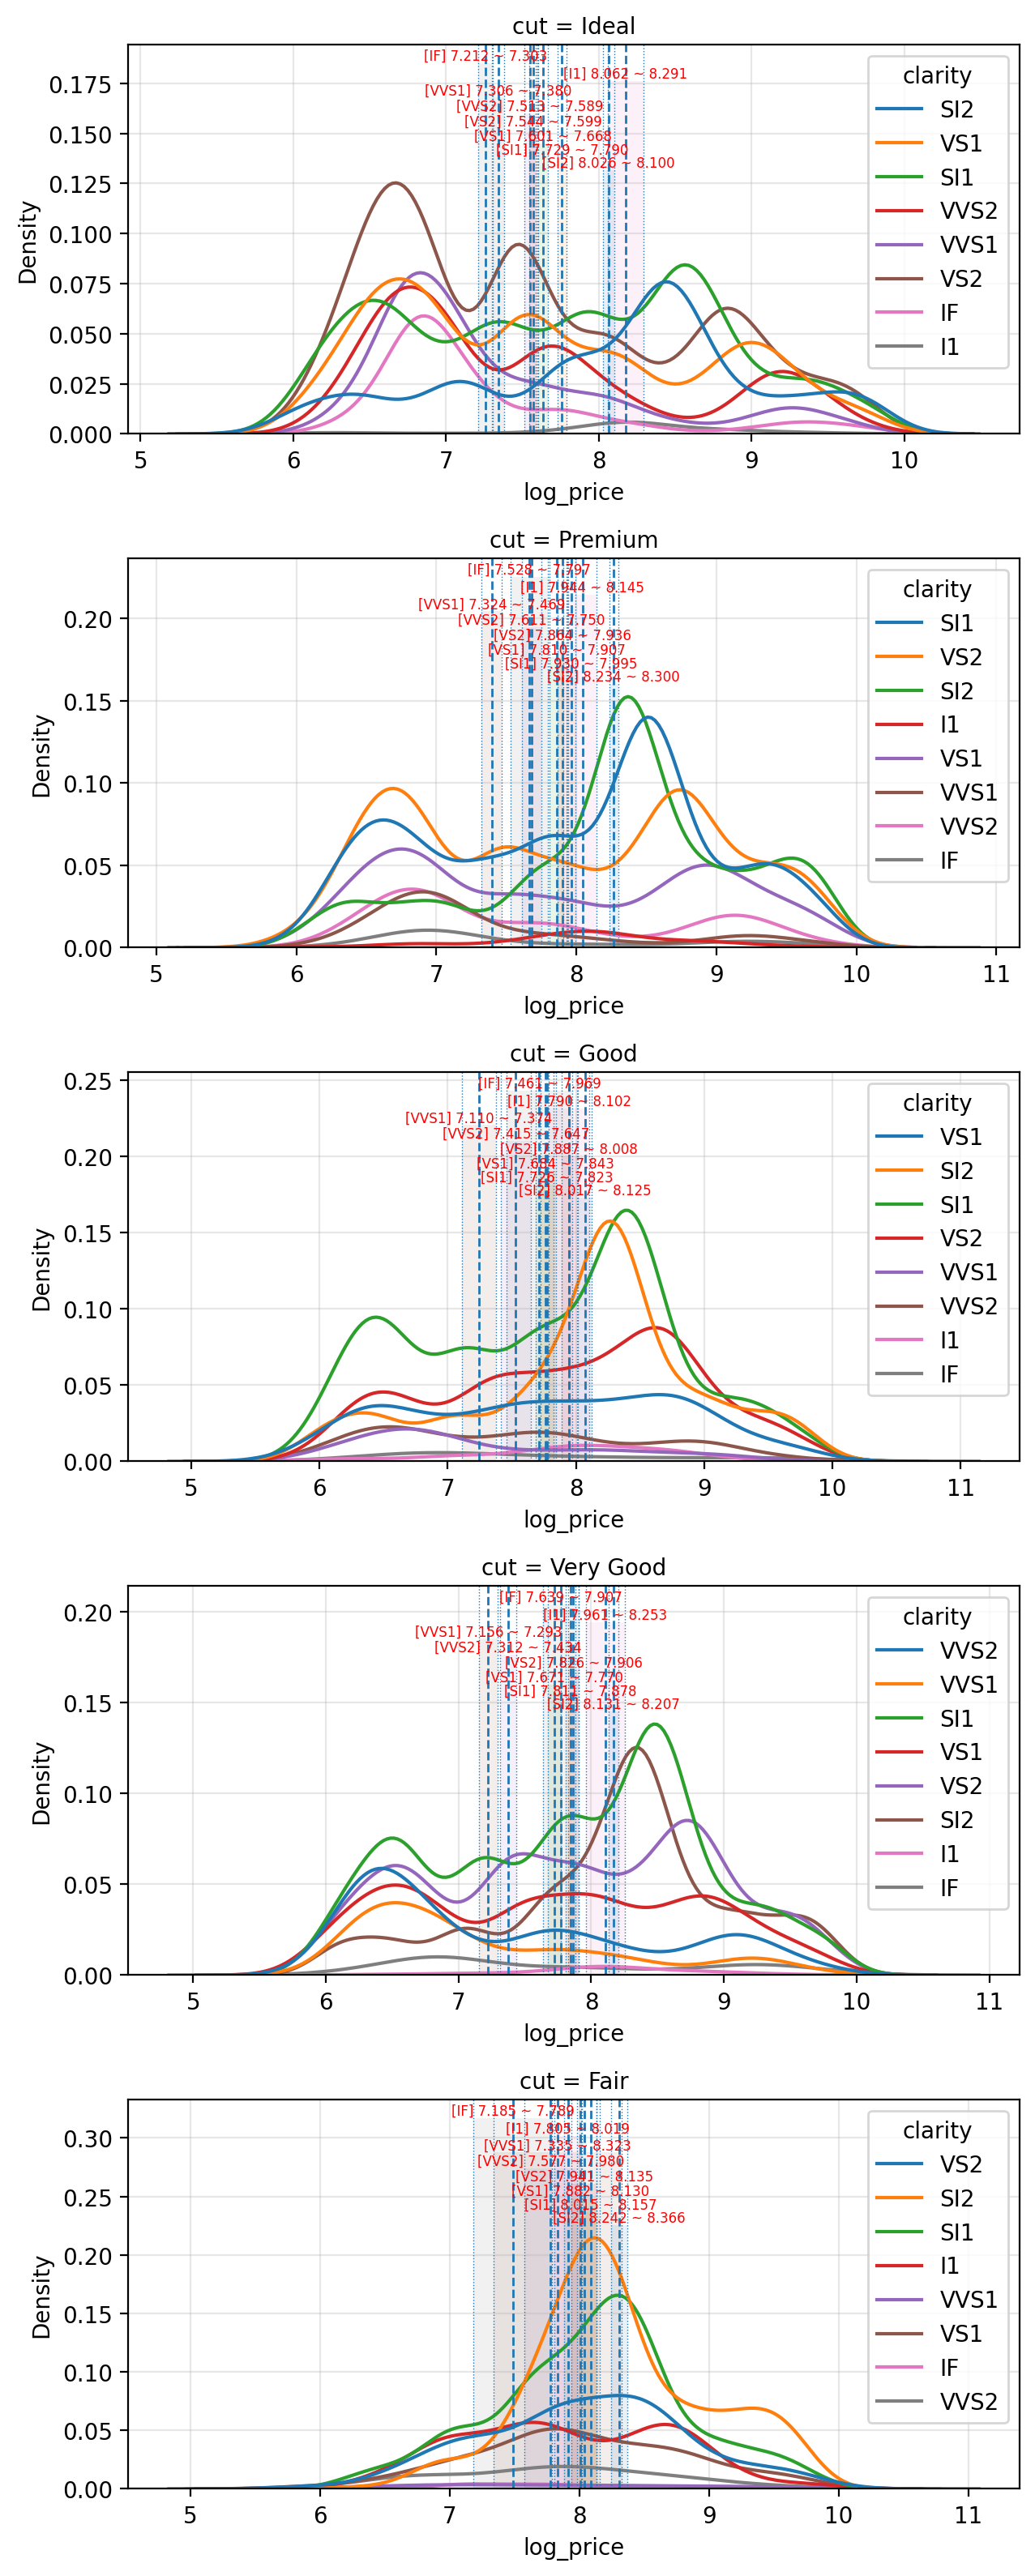

In [74]:
field = "log_price"
group_field = "cut"
hue_field = "clarity"


data = df2[[field, group_field, hue_field]].dropna().copy()

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]

    # KDE Plot
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        n = len(temp_sub[field])

        # 표본이 너무 적으면 신뢰구간 계산 불가 → 스킵
        if n < 2:
            continue

        clevel = 0.95
        dof = n - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(n)

        if not (sp_std_error > 0):
            continue

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        # 신뢰구간 경계선
        ax[i].axvline(cmin, linestyle=":", linewidth=0.5)
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5)

        # 평균 및 신뢰구간 영역 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle="--", linewidth=1)

        # 텍스트
        ax[i].text(
            x=(cmax - cmin) / 2 + cmin,
            y=ymax,
            s="[%s] %0.3f ~ %0.3f" % (h, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"},
        )

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

In [75]:
xname = ["cut", "clarity"]
yname = "log_price"
data = df8[xname + [yname]]

pg_anova = anova(data=data, dv=yname, between=xname, detailed=True)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row["Source"]
    p_val = row["p-unc"]

    if p_val <= 0.05:
        print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

Source            SS       DF          MS           F  \
0            cut    458.689464      4.0  114.672366  119.056605   
1        clarity   2282.813705      7.0  326.116244  338.584563   
2  cut * clarity    300.567361     28.0   10.734549   11.144960   
3       Residual  51756.217644  53735.0    0.963175         NaN   

           p-unc       np2  
0  2.624736e-101  0.008785  
1   0.000000e+00  0.042244  
2   1.435389e-49  0.005774  
3            NaN       NaN

→ cut 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ cut * clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [76]:
xname = ["cut", "clarity"]
yname = "log_price"

data = df8[xname + [yname]]

levels = {}  # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname:  # 요인을 하나씩 꺼냄
    level_count = data[factor].nunique()  # 요인의 수준 수 계산
    levels[factor] = level_count  # 딕셔너리에 저장

pvals = {}  # 빈 딕셔너리 만들기
# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows():  # 행을 하나씩 꺼냄
    source_name = row["Source"]  # 요인 이름
    p_value = row["p-unc"]  # 각 요인의 p-value
    pvals[source_name] = p_value  # 딕셔너리에 저장

# 주효과 사후검정
for factor in xname:
    print(f"\n[{factor}]")

    # 수준이 2개면 사후검정 필요 없음
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if "*" in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[cut]
- 주효과 유의 (p=2.62e-101) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A          B   mean(A)   mean(B)      diff        se          T  \
0     Fair       Good  8.090289  7.840509  0.249780  0.023727  10.527108   
1     Fair      Ideal  8.090289  7.640958  0.449331  0.020303  22.131770   
2     Fair    Premium  8.090289  7.949959  0.140330  0.021060   6.663216   
3     Fair  Very Good  8.090289  7.798623  0.291666  0.021342  13.666427   
4     Good      Ideal  7.840509  7.640958  0.199551  0.015572  12.814638   
5     Good    Premium  7.840509  7.949959 -0.109450  0.016548  -6.614109   
6     Good  Very Good  7.840509  7.798623  0.041886  0.016905   2.477781   
7    Ideal    Premium  7.640958  7.949959 -0.309001  0.011093 -27.856757   
8    Ideal  Very Good  7.640958  7.798623 -0.157665  0.011618 -13.570723   
9  Premium  Very Good  7.949959  7.798623  0.151337  0.012897  11.734559   

             df          pval    hedges  
0   3445.043360  1.948108e-12  0.267979  
1   2018.137568  4.981571e-13  0.459203  
2   2327.464969  3.321803e-10  0.139562  
3   2447.897947  0.000000e+00  0.289017  
4   7340.800370  4.550804e-13  0.201506  
5   8984.457292  4.000353e-10 -0.107612  
6   9528.343382  9.574532e-02  0.041019  
7  28475.738548  0.000000e+00 -0.306785  
8  24093.884656  2.653544e-12 -0.156290  
9  25329.519422  0.000000e+00  0.146468


[clarity]
- 주효과 유의 (p=0) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A     B   mean(A)   mean(B)      diff        se          T  \
0     I1    IF  8.027337  7.406446  0.620891  0.034991  17.744403   
1     I1   SI1  8.027337  7.847979  0.179358  0.028714   6.246416   
2     I1   SI2  8.027337  8.165532 -0.138195  0.029007  -4.764135   
3     I1   VS1  8.027337  7.725674  0.301663  0.029724  10.148744   
4     I1   VS2  8.027337  7.763671  0.263666  0.028926   9.115057   
5     I1  VVS1  8.027337  7.323430  0.703907  0.031121  22.618445   
6     I1  VVS2  8.027337  7.531702  0.495635  0.030938  16.020472   
7     IF   SI1  7.406446  7.847979 -0.441533  0.023450 -18.828438   
8     IF   SI2  7.406446  8.165532 -0.759086  0.023809 -31.882393   
9     IF   VS1  7.406446  7.725674 -0.319228  0.024677 -12.936150   
10    IF   VS2  7.406446  7.763671 -0.357225  0.023710 -15.066248   
11    IF  VVS1  7.406446  7.323430  0.083016  0.026343   3.151350   
12    IF  VVS2  7.406446  7.531702 -0.125256  0.026126  -4.794289   
13   SI1   SI2  7.847979  8.165532 -0.317553  0.012922 -24.573831   
14   SI1   VS1  7.847979  7.725674  0.122305  0.014460   8.458246   
15   SI1   VS2  7.847979  7.763671  0.084308  0.012740   6.617748   
16   SI1  VVS1  7.847979  7.323430  0.524549  0.017149  30.588534   
17   SI1  VVS2  7.847979  7.531702  0.316277  0.016814  18.810819   
18   SI2   VS1  8.165532  7.725674  0.439858  0.015034  29.256636   
19   SI2   VS2  8.165532  7.763671  0.401861  0.013388  30.015731   
20   SI2  VVS1  8.165532  7.323430  0.842102  0.017636  47.749639   
21   SI2  VVS2  8.165532  7.531702  0.633830  0.017310  36.615925   
22   VS1   VS2  7.725674  7.763671 -0.037997  0.014878  -2.553943   
23   VS1  VVS1  7.725674  7.323430  0.402244  0.018791  21.405663   
24   VS1  VVS2  7.725674  7.531702  0.193972  0.018486  10.492750   
25   VS2  VVS1  7.763671  7.323430  0.440241  0.017502  25.153247   
26   VS2  VVS2  7.763671  7.531702  0.231969  0.017174  13.506769   
27  VVS1  VVS2  7.323430  7.531702 -0.208272  0.020657 -10.082195   

              df          pval    hedges  
0    1684.983002  0.000000e+00  0.711501  
1     890.216775  1.816305e-08  0.183546  
2     926.592970  5.991331e-05 -0.152666  
3    1019.924542  0.000000e+00  0.294574  
4     916.657672  0.000000e+00  0.258809  
5    1208.269133  0.000000e+00  0.808745  
6    1187.133740  2.690070e-13  0.498885  
7    2382.684499  0.000000e+00 -0.450186  
8    2522.009603  0.000000e+00 -0.827275  
9    2881.590505  1.264544e-13 -0.311636  
10   2486.357424  1.033840e-12 -0.350435  
11   3448.329282  3.502545e-02  0.091965  
12   3450.652451  4.649030e-05 -0.125422  
13  20545.161618  7.153167e-12 -0.330857  
14  16583.057246  1.481892e-11  0.120972  
15  24964.678081  1.041004e-09  0.083441  
16   6360.472178  6.754597e-13  0.541462  
17   8915.381766  0.000000e+00  0.316616  
18  16325.333709  0.000000e+00  0.448946  
19  20749.282212  0.000000e+00  0.407971  
20   6865.616588  0.000000e+00  0.924958  
21   9493.901652  0.000000e+00  0.662480  
22  17327.851283  1.732000e-01 -0.036603  
23   8113.497187  2.060685e-12  0.401758  
24  10877.871504  0.000000e+00  0.186921  
25   6806.119097  1.176836e-12  0.439045  
26   9502.686357  2.031708e-14  0.225083  
27   8392.989391  0.000000e+00 -0.214262


[cut * clarity] 상호작용 효과
- 상호작용 유의 (p=1.44e-49) → 단순주효과 분석 필요


cut * clarity 이원분산 사후검정(Games–Howell) 결과, 평균(log_price) 차이는 대부분의 조합에서 유의하였다.(p≤0.05).
평균값(mean) 기준으로는 SI2(8.166) > I1(8.027) > SI1(7.848) > VS2(7.763) > VS1(7.725) > VVS2(7.531) > IF(7.405) > VVS1(7.322) 순으로 나타난다.
따라서 [cut × clarity] 상호작용 효과는 유의하였다(p=2.56e-49).

In [94]:
dff = df2[["color", "clarity", "log_price"]].copy()
dff

color clarity  log_price
0         E     SI2   5.786897
1         E     SI1   5.786897
2         E     VS1   5.789960
3         I     VS2   5.811141
4         J     SI2   5.814131
...     ...     ...        ...
53935     D     SI1   7.921898
53936     D     SI1   7.921898
53937     D     SI1   7.921898
53938     H     SI2   7.921898
53939     D     SI2   7.921898

[53775 rows x 3 columns]

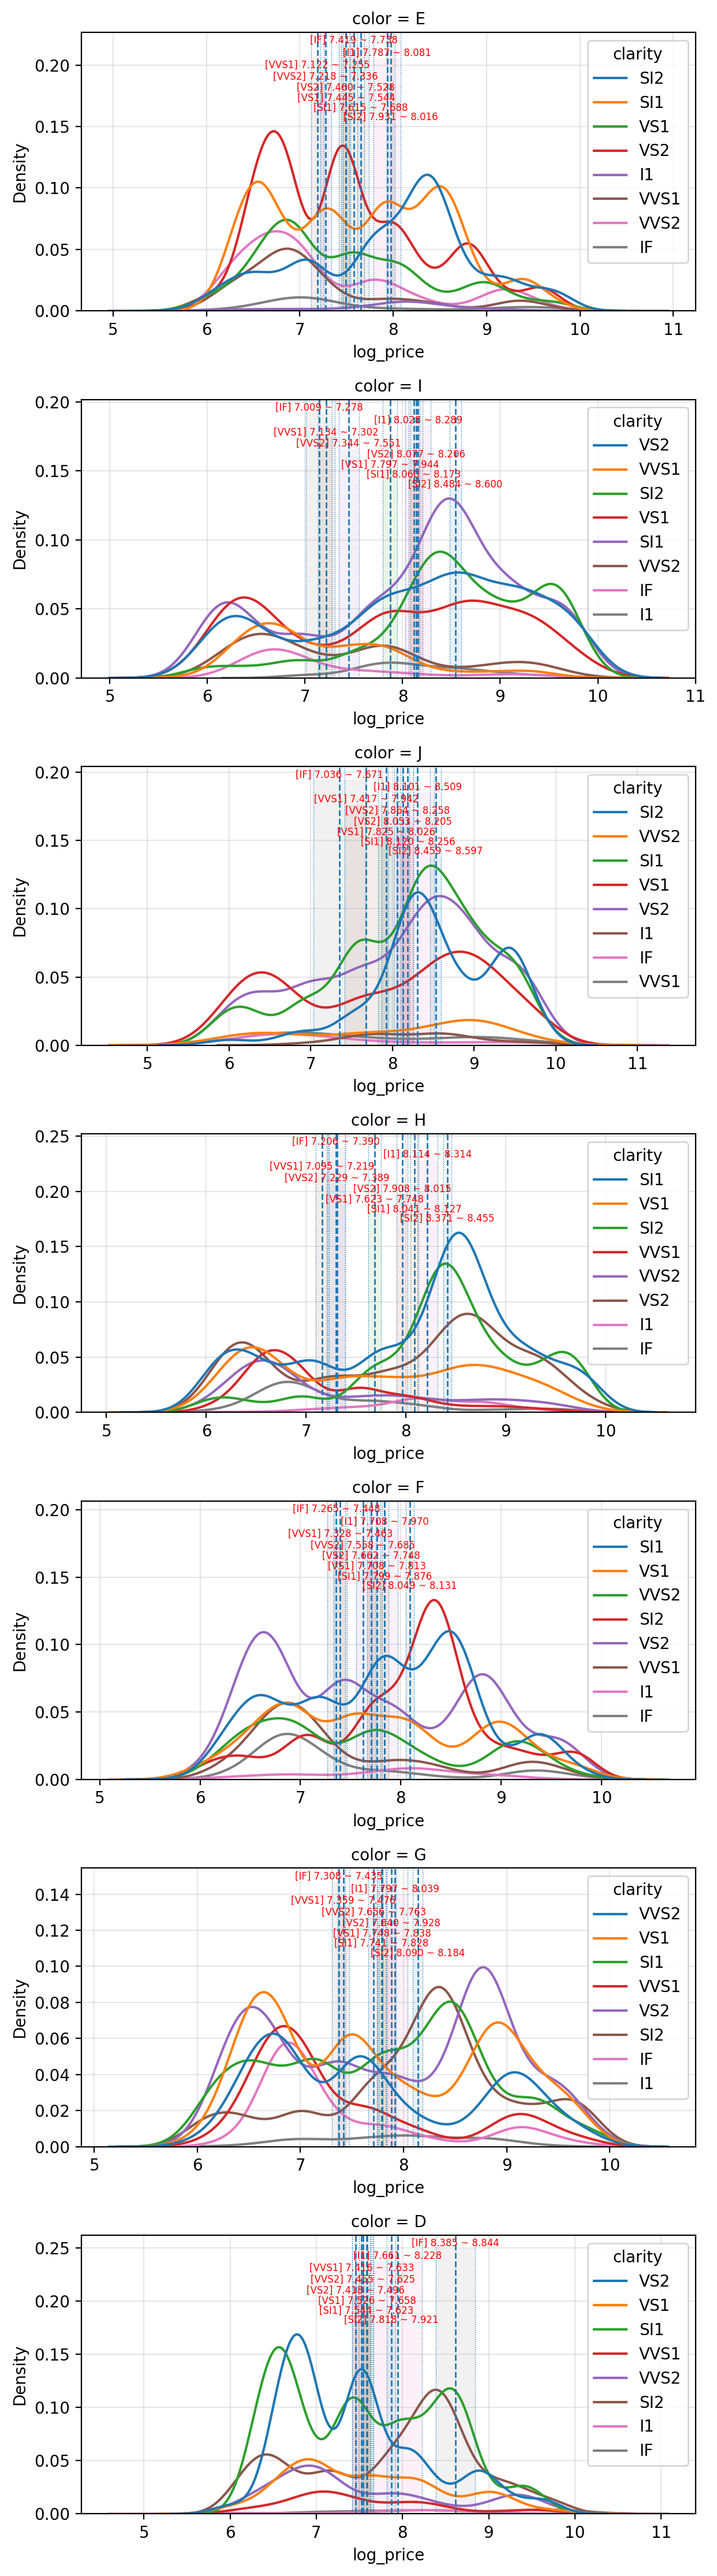

In [95]:
field = "log_price"
group_field = "color"
hue_field = "clarity"


data = dff[[field, group_field, hue_field]].dropna().copy()

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]

    # KDE Plot
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        n = len(temp_sub[field])

        # 표본이 너무 적으면 신뢰구간 계산 불가 → 스킵
        if n < 2:
            continue

        clevel = 0.95
        dof = n - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(n)

        if not (sp_std_error > 0):
            continue

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        # 신뢰구간 경계선
        ax[i].axvline(cmin, linestyle=":", linewidth=0.5)
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5)

        # 평균 및 신뢰구간 영역 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle="--", linewidth=1)

        # 텍스트
        ax[i].text(
            x=(cmax - cmin) / 2 + cmin,
            y=ymax,
            s="[%s] %0.3f ~ %0.3f" % (h, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"},
        )

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

In [96]:
xname = ["color", "clarity"]
yname = "log_price"
data = dff[xname + [yname]]

pg_anova = anova(data=data, dv=yname, between=xname, detailed=True)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row["Source"]
    p_val = row["p-unc"]

    if p_val <= 0.05:
        print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

Source            SS       DF          MS           F  \
0            color   1464.857041      6.0  244.142840  261.077908   
1          clarity   2858.722335      7.0  408.388905  436.716968   
2  color * clarity    816.151645     42.0   19.432182   20.780103   
3         Residual  50234.465784  53719.0    0.935134         NaN   

           p-unc       np2  
0   0.000000e+00  0.028334  
1   0.000000e+00  0.053843  
2  1.993635e-154  0.015987  
3            NaN       NaN

→ color 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ color * clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [97]:
xname = ["color", "clarity"]
yname = "log_price"

data = dff[xname + [yname]]

levels = {}  # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname:  # 요인을 하나씩 꺼냄
    level_count = data[factor].nunique()  # 요인의 수준 수 계산
    levels[factor] = level_count  # 딕셔너리에 저장

pvals = {}  # 빈 딕셔너리 만들기
# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows():  # 행을 하나씩 꺼냄
    source_name = row["Source"]  # 요인 이름
    p_value = row["p-unc"]  # 각 요인의 p-value
    pvals[source_name] = p_value  # 딕셔너리에 저장

# 주효과 사후검정
for factor in xname:
    print(f"\n[{factor}]")

    # 수준이 2개면 사후검정 필요 없음
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if "*" in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[color]
- 주효과 유의 (p=0) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A  B   mean(A)   mean(B)      diff        se          T            df  \
0   D  E  7.618173  7.580117  0.038056  0.014652   2.597212  14515.582383   
1   D  F  7.618173  7.762781 -0.144609  0.015014  -9.631319  14916.864602   
2   D  G  7.618173  7.789751 -0.171579  0.014861 -11.545292  15379.789166   
3   D  H  7.618173  7.917375 -0.299202  0.016231 -18.434102  14954.249959   
4   D  I  7.618173  8.020211 -0.402038  0.018794 -21.391367  10523.292778   
5   D  J  7.618173  8.147775 -0.529603  0.022595 -23.439374   4747.645070   
6   E  F  7.580117  7.762781 -0.182664  0.013642 -13.390158  19193.887347   
7   E  G  7.580117  7.789751 -0.209634  0.013473 -15.559550  21000.149239   
8   E  H  7.580117  7.917375 -0.337258  0.014970 -22.528700  16529.605620   
9   E  I  7.580117  8.020211 -0.440094  0.017717 -24.840170   9608.691599   
10  E  J  7.580117  8.147775 -0.567658  0.021707 -26.151383   4165.794903   
11  F  G  7.762781  7.789751 -0.026970  0.013866  -1.945079  20530.433601   
12  F  H  7.762781  7.917375 -0.154594  0.015325 -10.087959  16866.993555   
13  F  I  7.762781  8.020211 -0.257430  0.018018 -14.287763  10050.514889   
14  F  J  7.762781  8.147775 -0.384994  0.021953 -17.537551   4338.982695   
15  G  H  7.789751  7.917375 -0.127624  0.015175  -8.410324  17473.651581   
16  G  I  7.789751  8.020211 -0.230460  0.017890 -12.881935   9993.562714   
17  G  J  7.789751  8.147775 -0.358024  0.021848 -16.386924   4275.821022   
18  H  I  7.917375  8.020211 -0.102836  0.019043  -5.400176  11221.199113   
19  H  J  7.917375  8.147775 -0.230401  0.022802 -10.104463   4936.608079   
20  I  J  8.020211  8.147775 -0.127564  0.024692  -5.166148   5998.441032   

            pval    hedges  
0   1.267697e-01  0.041096  
1   0.000000e+00 -0.152092  
2   0.000000e+00 -0.173158  
3   0.000000e+00 -0.298239  
4   6.181611e-12 -0.398023  
5   1.591172e-12 -0.551687  
6   3.663736e-14 -0.192929  
7   6.617262e-12 -0.213547  
8   0.000000e+00 -0.340476  
9   2.900347e-12 -0.442875  
10  0.000000e+00 -0.596485  
11  4.502827e-01 -0.026951  
12  0.000000e+00 -0.152657  
13  0.000000e+00 -0.252378  
14  1.362688e-12 -0.391283  
15  0.000000e+00 -0.122437  
16  3.828604e-12 -0.218710  
17  0.000000e+00 -0.347760  
18  1.417119e-06 -0.095257  
19  1.368905e-13 -0.218254  
20  5.126327e-06 -0.117808


[clarity]
- 주효과 유의 (p=0) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


A     B   mean(A)   mean(B)      diff        se          T  \
0     I1    IF  8.027337  7.406446  0.620891  0.034991  17.744403   
1     I1   SI1  8.027337  7.847979  0.179358  0.028714   6.246416   
2     I1   SI2  8.027337  8.165532 -0.138195  0.029007  -4.764135   
3     I1   VS1  8.027337  7.725674  0.301663  0.029724  10.148744   
4     I1   VS2  8.027337  7.763671  0.263666  0.028926   9.115057   
5     I1  VVS1  8.027337  7.323430  0.703907  0.031121  22.618445   
6     I1  VVS2  8.027337  7.531702  0.495635  0.030938  16.020472   
7     IF   SI1  7.406446  7.847979 -0.441533  0.023450 -18.828438   
8     IF   SI2  7.406446  8.165532 -0.759086  0.023809 -31.882393   
9     IF   VS1  7.406446  7.725674 -0.319228  0.024677 -12.936150   
10    IF   VS2  7.406446  7.763671 -0.357225  0.023710 -15.066248   
11    IF  VVS1  7.406446  7.323430  0.083016  0.026343   3.151350   
12    IF  VVS2  7.406446  7.531702 -0.125256  0.026126  -4.794289   
13   SI1   SI2  7.847979  8.165532 -0.317553  0.012922 -24.573831   
14   SI1   VS1  7.847979  7.725674  0.122305  0.014460   8.458246   
15   SI1   VS2  7.847979  7.763671  0.084308  0.012740   6.617748   
16   SI1  VVS1  7.847979  7.323430  0.524549  0.017149  30.588534   
17   SI1  VVS2  7.847979  7.531702  0.316277  0.016814  18.810819   
18   SI2   VS1  8.165532  7.725674  0.439858  0.015034  29.256636   
19   SI2   VS2  8.165532  7.763671  0.401861  0.013388  30.015731   
20   SI2  VVS1  8.165532  7.323430  0.842102  0.017636  47.749639   
21   SI2  VVS2  8.165532  7.531702  0.633830  0.017310  36.615925   
22   VS1   VS2  7.725674  7.763671 -0.037997  0.014878  -2.553943   
23   VS1  VVS1  7.725674  7.323430  0.402244  0.018791  21.405663   
24   VS1  VVS2  7.725674  7.531702  0.193972  0.018486  10.492750   
25   VS2  VVS1  7.763671  7.323430  0.440241  0.017502  25.153247   
26   VS2  VVS2  7.763671  7.531702  0.231969  0.017174  13.506769   
27  VVS1  VVS2  7.323430  7.531702 -0.208272  0.020657 -10.082195   

              df          pval    hedges  
0    1684.983002  0.000000e+00  0.711501  
1     890.216775  1.816305e-08  0.183546  
2     926.592970  5.991331e-05 -0.152666  
3    1019.924542  0.000000e+00  0.294574  
4     916.657672  0.000000e+00  0.258809  
5    1208.269133  0.000000e+00  0.808745  
6    1187.133740  2.690070e-13  0.498885  
7    2382.684499  0.000000e+00 -0.450186  
8    2522.009603  0.000000e+00 -0.827275  
9    2881.590505  1.264544e-13 -0.311636  
10   2486.357424  1.033840e-12 -0.350435  
11   3448.329282  3.502545e-02  0.091965  
12   3450.652451  4.649030e-05 -0.125422  
13  20545.161618  7.153167e-12 -0.330857  
14  16583.057246  1.481892e-11  0.120972  
15  24964.678081  1.041004e-09  0.083441  
16   6360.472178  6.754597e-13  0.541462  
17   8915.381766  0.000000e+00  0.316616  
18  16325.333709  0.000000e+00  0.448946  
19  20749.282212  0.000000e+00  0.407971  
20   6865.616588  0.000000e+00  0.924958  
21   9493.901652  0.000000e+00  0.662480  
22  17327.851283  1.732000e-01 -0.036603  
23   8113.497187  2.060685e-12  0.401758  
24  10877.871504  0.000000e+00  0.186921  
25   6806.119097  1.176836e-12  0.439045  
26   9502.686357  2.031708e-14  0.225083  
27   8392.989391  0.000000e+00 -0.214262


[color * clarity] 상호작용 효과
- 상호작용 유의 (p=1.99e-154) → 단순주효과 분석 필요


color * clarity 사후검정(Games–Howell) 결과, 평균(log_price) 차이는 대부분의 조합에서 유의하였다.(p≤0.05).
따라서 [color × clarity] 상호작용 효과는 유의하였다(p=1.99e-154).

이후 분석에서는 명목형변수들 사이의 교호작용을 포함하여 회귀분석을 추가적으로 진행하고자 한다

## 📝미션 8. “가격과 가장 가까운 물리적 변수는?”

In [77]:
df8 = df2.filter(["log_price", "log_carat", "x", "y", "z", "depth", "table"])
df8

log_price  log_carat     x     y     z  depth  table
0       5.786897  -1.469676  3.95  3.98  2.43   61.5   55.0
1       5.786897  -1.560648  3.89  3.84  2.31   59.8   61.0
2       5.789960  -1.469676  4.05  4.07  2.31   56.9   65.0
3       5.811141  -1.237874  4.20  4.23  2.63   62.4   58.0
4       5.814131  -1.171183  4.34  4.35  2.75   63.3   58.0
...          ...        ...   ...   ...   ...    ...    ...
53935   7.921898  -0.328504  5.75  5.76  3.50   60.8   57.0
53936   7.921898  -0.328504  5.69  5.75  3.61   63.1   55.0
53937   7.921898  -0.356675  5.66  5.68  3.56   62.8   60.0
53938   7.921898  -0.150823  6.15  6.12  3.74   61.0   58.0
53939   7.921898  -0.287682  5.83  5.87  3.64   62.2   55.0

[53775 rows x 7 columns]

In [78]:
skew_outlier = {}
for col in df8.columns:
    temp = df8[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()
    skew_outlier[col] = {
        "original_skew": skew_original,
        "log_skew": skew_log,
        "outliers(|z|>3)": outlier_count,
    }
skew_outlier_df = DataFrame(skew_outlier).T
skew_outlier_df

original_skew  log_skew  outliers(|z|>3)
log_price       0.114487 -0.227336              0.0
log_carat       0.094553 -0.146329              6.0
x               0.396908 -0.014382             35.0
y               2.470200  0.014237             27.0
z               1.589309  0.193769             34.0
depth          -0.113711 -2.199048            681.0
table           0.792069  0.156996            334.0

In [79]:
rows = []

for a, b in combinations(df8.columns, 2):
    x = df8[a]
    y = df8[b]

    # [1] 선형성 확인 (Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue > 0.05

    # [2] 이상치 존재 여부(|z|>3 기준)
    a_flag = skew_outlier_df.loc[a, "outliers(|z|>3)"] > 0
    b_flag = skew_outlier_df.loc[b, "outliers(|z|>3)"] > 0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = "pearson"
        corr, pval = pearsonr(x, y)
    else:
        chosen = "spearman"
        corr, pval = spearmanr(x, y)

    # [4] 유의성 판단 (p <= 0.05)
    significant = pval <= 0.05

    # [5] 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = "Very strong"
    elif abs_r >= 0.60:
        strength = "Strong"
    elif abs_r >= 0.40:
        strength = "Medium"
    elif abs_r >= 0.20:
        strength = "Weak"
    else:
        strength = "Very weak"

    # [6] 행 추가
    rows.append(
        {
            "var_a": a,
            "var_b": b,
            "linearity": linearity_ok,
            "outlier_flag": outlier_flag,
            "chosen": chosen,
            "corr": corr,
            "pval": pval,
            "significant": significant,
            "strength": strength,
        }
    )

summary_df = DataFrame(rows)
summary_df

var_a      var_b  linearity  outlier_flag    chosen      corr  \
0   log_price  log_carat      False          True  spearman  0.962930   
1   log_price          x      False          True  spearman  0.963797   
2   log_price          y      False          True  spearman  0.963263   
3   log_price          z      False          True  spearman  0.958652   
4   log_price      depth      False          True  spearman  0.010172   
5   log_price      table      False          True  spearman  0.171032   
6   log_carat          x      False          True  spearman  0.996661   
7   log_carat          y      False          True  spearman  0.996048   
8   log_carat          z      False          True  spearman  0.994755   
9   log_carat      depth       True          True  spearman  0.030334   
10  log_carat      table       True          True  spearman  0.194126   
11          x          y       True          True  spearman  0.997959   
12          x          z      False          True  spearman  0.988393   
13          x      depth      False          True  spearman -0.023094   
14          x      table      False          True  spearman  0.201478   
15          y          z      False          True  spearman  0.988158   
16          y      depth       True          True  spearman -0.025057   
17          y      table      False          True  spearman  0.195000   
18          z      depth      False          True  spearman  0.103665   
19          z      table      False          True  spearman  0.159471   
20      depth      table      False          True  spearman -0.245184   

             pval  significant     strength  
0    0.000000e+00         True  Very strong  
1    0.000000e+00         True  Very strong  
2    0.000000e+00         True  Very strong  
3    0.000000e+00         True  Very strong  
4    1.833012e-02         True    Very weak  
5    0.000000e+00         True    Very weak  
6    0.000000e+00         True  Very strong  
7    0.000000e+00         True  Very strong  
8    0.000000e+00         True  Very strong  
9    1.982387e-12         True    Very weak  
10   0.000000e+00         True    Very weak  
11   0.000000e+00         True  Very strong  
12   0.000000e+00         True  Very strong  
13   8.507912e-08         True    Very weak  
14   0.000000e+00         True         Weak  
15   0.000000e+00         True  Very strong  
16   6.197201e-09         True    Very weak  
17   0.000000e+00         True    Very weak  
18  2.278996e-128         True    Very weak  
19  3.495126e-303         True    Very weak  
20   0.000000e+00         True         Weak

In [80]:
# 1) 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df["var_a"]).union(summary_df["var_b"]))
# 2) 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)
# 3) summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row["var_a"], row["var_b"], row["corr"]
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r  # 대칭
# 4) 대각선(diagonal)을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)
corr_matrix

depth  log_carat  log_price     table         x         y  \
depth      1.000000   0.030334   0.010172 -0.245184 -0.023094 -0.025057   
log_carat  0.030334   1.000000   0.962930  0.194126  0.996661  0.996048   
log_price  0.010172   0.962930   1.000000  0.171032  0.963797  0.963263   
table     -0.245184   0.194126   0.171032  1.000000  0.201478  0.195000   
x         -0.023094   0.996661   0.963797  0.201478  1.000000  0.997959   
y         -0.025057   0.996048   0.963263  0.195000  0.997959  1.000000   
z          0.103665   0.994755   0.958652  0.159471  0.988393  0.988158   

                  z  
depth      0.103665  
log_carat  0.994755  
log_price  0.958652  
table      0.159471  
x          0.988393  
y          0.988158  
z          1.000000

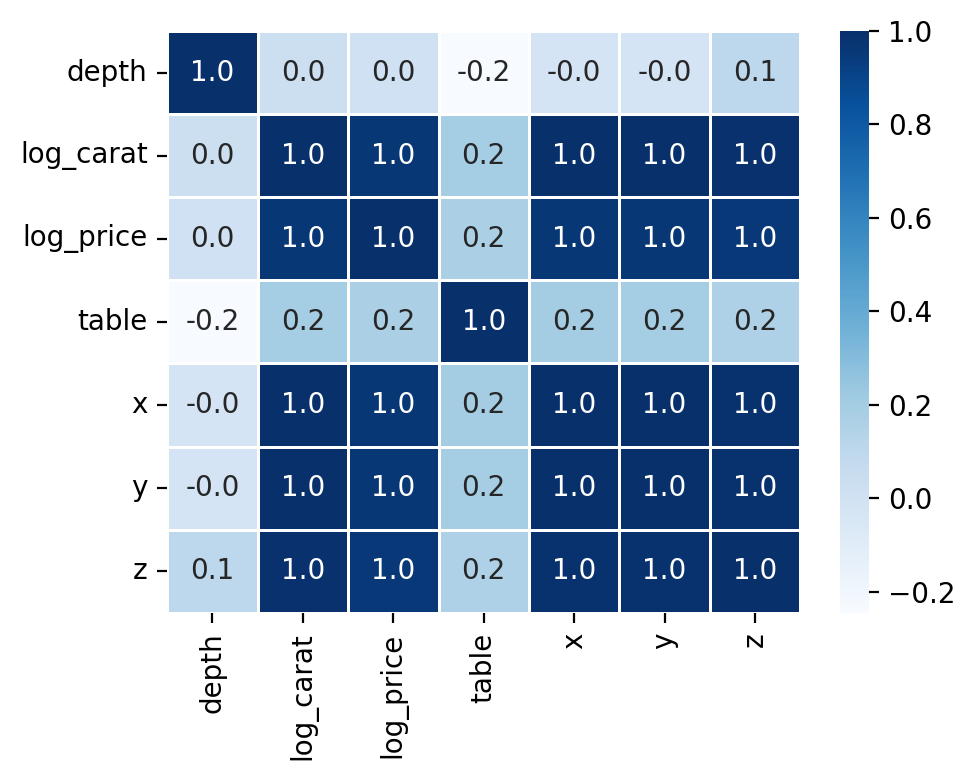

In [81]:
# 1) 그래프 초기화
width_px = 1000  # 그래프 가로 크기
height_px = 800  # 그래프 세로 크기
rows = 1  # 그래프 행 수
cols = 1  # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) heatmap 그리기
sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.1f",
    linewidth=0.5,
    cmap="Blues",
    annot_kws={"size": 10},
)
# 4) 출력
plt.tight_layout()  # 여백 제거
plt.show()  # 그래프 화면 출력
plt.close()  # 그래프 작업 종료

가격 분포에 왜도랑 이상치가 존재하여 Pearson보다 Spearman(순위 기반)으로 해석하였다.
그 결과 price는 x가 가장 강하게 연결되어 있었고(r=0.96), y·carat·z도 거의 비슷하게 매우 높았다.
즉 다이아가 커질수록(무게/치수 증가) 가격도 같이 올라가는 경향이 뚜렷했고, depth나 table처럼 비율 변수는 가격과 관계가 약했다.

## 미션 9. “상관관계는 곧 원인일까?
상관이 높다는 것은 무엇을 의미하는가?
이 결과를 그대로 “원인”이라고 말해도 될까?

상관이 높다는 것은 두 변수가 함께 커지거나 작아지는 경향이 강하다는 뜻이다.
하지만 상관분석은 cut/color/clarity 같은 다른 요인을 통제하지 못하므로, 이 결과를 그대로 원인이라고 단정할 수는 없다.
또한 비선형 관계, 이상치 영향 때문에 상관이 더 작게 또는 크게 보일 수도 있다.
따라서 크기 변수들이 강하게 연결돼 있다는 관찰로 해석하고, 원인 판단은 추가 검증이 필요한 영역으로 남겨두는 것이 타당하다.